In [1]:
import yaml
import cv2
import matplotlib.pyplot as plt
from types import SimpleNamespace
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import json
import scipy
import rasterio
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import copy
from matplotlib import font_manager as fm
from scipy.stats import yeojohnson
import h5py
from joblib import Parallel, delayed

mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def create_folder(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
def cov_center(data, level=0.95):
    env = EllipticEnvelope(support_fraction=level).fit(data)
    center = env.location_
    covariance = env.covariance_
    return center, covariance

def plot_ellipse(center, covariance, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    在给定的轴上绘制一个椭圆。

    :param center: 椭圆的中心点。
    :param covariance: 椭圆的协方差矩阵。
    :param ax: matplotlib 轴对象。
    :param n_std: 确定椭圆大小的标准差倍数。
    :param facecolor: 椭圆的填充颜色。
    :param kwargs: 传递给 Ellipse 对象的其他参数。
    """
    # 计算协方差矩阵的特征值和特征向量
    eigenvals, eigenvecs = np.linalg.eigh(covariance)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]

    # 计算椭圆的宽度和高度
    width, height = 2 * n_std * np.sqrt(eigenvals)
    angle = np.degrees(np.arctan2(*eigenvecs[:,0][::-1]))

    # 创建并添加椭圆形状
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)
    
def png_operation(rst):
    grid_normalized = cv2.normalize(rst, None, 0, 255, cv2.NORM_MINMAX)
    grid_uint8 = grid_normalized.astype(np.uint8)
    colored_image = cv2.applyColorMap(grid_uint8, cv2.COLORMAP_JET)
    # 設定要調整的尺寸，例如 300x300
    new_size = (300, 300)
    # 調整 PNG 的大小
    resized_png = cv2.resize(colored_image, new_size, interpolation=cv2.INTER_CUBIC)
    return resized_png

# 計算兩個經緯度點之間的距離，支持向量化操作
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 地球半徑，單位：公里
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(lat2), np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def get_chinese_sciname(target_name):
    change_names = {
    'Anas_zonorhyncha': 'Anas_poecilorhyncha', 
    'Cyanoderma_ruficeps': 'Stachyridopsis_ruficeps', 
    'Erythrogenys_erythrocnemis': 'Pomatorhinus_erythrocnemis', 
    'Ictinaetus_malaiensis': 'Ictinaetus_malayensis', 
    'Lewinia_striata': 'Gallirallus_striatus', 
    'Machlolophus_holsti': 'Parus_holsti', 
    'Pterorhinus_poecilorhynchus': 'Garrulax_poecilorhynchus', 
    'Pterorhinus_ruficeps': 'Garrulax_ruficeps', 
    'Schoeniparus_brunneus': 'Alcippe_brunnea', 
    'Sittiparus_castaneoventris': 'Poecile_varius', 
    'Synoicus_chinensis': 'Coturnix_chinensis', 
    'Taenioptynx_brodiei': 'Glaucidium_brodiei', 
    'Tarsiger_formosanus': 'Tarsiger_indicus', 
    'Turdus_niveiceps': 'Turdus_poliocephalus', 
    'Zapornia_fusca': 'Porzana_fusca'
    }
    df_name = pd.read_csv('../2023臺灣鳥類名錄-20230419.csv')
    for (new_name, orig_name) in change_names.items():
        if target_name == orig_name:
            target_name = new_name
            
    df_target = df_name[df_name['學名'] == target_name.replace('_', ' ')]
    return df_target['中文名'].values[0]

In [3]:
run_id = 'ba1815ca0ca14606962889c6eedb1316'
exp_id = '198698753857108054'
conf_path = os.path.join('mlruns', exp_id, run_id, 'artifacts', 'conf')
predicts_path = os.path.join('predicts', run_id)
plot_path = os.path.join('plots', run_id)
predicts_maxent_path = os.path.join('predict_maxent', run_id)

# DeepSDM configurations
DeepSDM_conf_path = os.path.join(conf_path, 'DeepSDM_conf.yaml')
with open(DeepSDM_conf_path, 'r') as f:
    DeepSDM_conf = SimpleNamespace(**yaml.load(f, Loader = yaml.FullLoader))
    
# load extent binary map
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    transform = f.transform
    height, width = f.shape
    lon_min, lat_max = rasterio.transform.xy(transform, 0, 0)  # 左上角
    lon_max, lat_min = rasterio.transform.xy(transform, height - 1, width - 1)  # 右下角
    meta = f.meta.copy()
    extent_binary = f.read(1)
extent_binary_extent = [lon_min, lon_max, lat_min, lat_max]

# create a plot folder of the specific exp_id
plot_path_heatmap = os.path.join(plot_path, 'Fig3_heatmap')
create_folder(plot_path_heatmap)
    
# species occurrence points
with open(os.path.join(predicts_path, 'sp_inf.json'), 'r') as f:
    sp_inf = json.load(f)
    
with open(os.path.join(conf_path, 'cooccurrence_vector.json')) as f:
    coocc_vector = json.load(f)
with open(os.path.join(conf_path, 'env_information.json')) as f:
    env_info = json.load(f)

In [4]:
species_list_predict = sorted(DeepSDM_conf.training_conf['species_list_predict'])

env_list = sorted(DeepSDM_conf.training_conf['env_list'])

date_list_predict = DeepSDM_conf.training_conf['date_list_predict']
date_list_train = DeepSDM_conf.training_conf['date_list_train']

DeepSDM_template = os.path.join('predicts', run_id, 'tif', '[SPECIES]_[TIME]_predict.tif')
maxent_template = os.path.join('predict_maxent', run_id, 'tif', 'all', f'[SPECIES]_[TIME]_maxent_all_season_{run_id}.tif')

### 繪製注意力分數的視覺化結果

### 以預測值來加權 attention score

In [65]:
import numpy as np

# 假設原始數據為 array
array = np.random.rand(560, 336)  # 創建一個 560x336 的陣列

# 重複 15 次，擴展為 15x560x336
expanded_array = np.tile(array, (15, 1, 1))

print(expanded_array.shape)  # 應輸出 (15, 560, 336)


(15, 560, 336)


In [70]:
def process_species(species, env_list, date_list_predict, predicts_path):
    sp_attention = np.zeros([len(env_list), 560, 336], dtype=np.float32)
    predict_sum = np.zeros([560, 336], dtype = np.float32)
    for date in date_list_predict:
        with rasterio.open(DeepSDM_template.replace('[SPECIES]', species).replace('[TIME]', date), 'r') as f:
            DeepSDM_predict = f.read(1)
        predict_sum += DeepSDM_predict
        with h5py.File(os.path.join(predicts_path, 'attention', f'{species}_{date}_attention.h5'), 'r') as hf:
            for i_env, env in enumerate(env_list):
                sp_attention[i_env] += hf[env][:] * DeepSDM_predict  # 直接累加

    # 處理數據，將小於0的值設為 NaN 並計算平均值
    sp_attention[sp_attention < 0] = np.nan
    species_attention = np.nanmean((sp_attention / np.tile(predict_sum, (len(env_list), 1, 1))), axis = (1,2))
    return [species] + species_attention.tolist()

# 並行處理所有物種
results = Parallel(n_jobs=-1)(
    delayed(process_species)(species, env_list, date_list_predict, predicts_path) 
    for species in species_list_predict
)

# 將結果轉換為 DataFrame
df_attention_weight = pd.DataFrame(results, columns=['species'] + env_list).set_index('species')

df_attention_weight_path = os.path.join(plot_path_heatmap, 'df_attention_weight.csv')
# df_attention_weight.to_csv(df_attention_weight_path)

In [71]:
env_list_detail = ['EVI', 'Cloud cover', 'Climate moisture index', 'Relative humidity', 'Landcover (PC1)', 'Landcover (PC2)', 'Landcover (PC3)', 'Landcover (PC4)', 'Landcover (PC5)',
 'Potential evapotranspiration', 'Precipitation', 'Shortwave radiation', 'Wind speed', 'Temperature', 'Vapor pressure deficit']

In [72]:
# df_attention_weight_path = os.path.join(plot_path_heatmap, 'df_attention_weight.csv')
# df_attention_weight = pd.read_csv(df_attention_weight_path, index_col=0)
df_attention_weight.columns = env_list_detail

# 創建 StandardScaler 實例
scaler = StandardScaler()

df_attention_weight_standard = df_attention_weight.copy()

# 對選定的列進行 normalization
df_attention_weight_standard[df_attention_weight.keys()] = scaler.fit_transform(df_attention_weight[df_attention_weight.keys()])

# 查看標準化後的 DataFrame
print(df_attention_weight_standard.head())

                                EVI  Cloud cover  Climate moisture index  \
species                                                                    
Abroscopus_albogularis    -0.626562    -0.415222               -0.596300   
Accipiter_trivirgatus      0.209283     0.634573                0.337669   
Accipiter_virgatus         0.184925     0.613424                0.313450   
Acridotheres_cristatellus  1.450215     1.152380                1.393239   
Actinodura_morrisoniana   -1.066546    -1.297903               -1.151377   

                           Relative humidity  Landcover (PC1)  \
species                                                         
Abroscopus_albogularis              0.544189        -0.307455   
Accipiter_trivirgatus              -0.393006         0.744117   
Accipiter_virgatus                 -0.370017         0.726062   
Acridotheres_cristatellus          -1.336980         1.006521   
Actinodura_morrisoniana             1.186853        -1.326229   

           

### 依據原本的attention score畫圓形的heatmap

### 物種名用中文

In [73]:
# 設置字體為 Noto Sans CJK
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # 檢查該路徑是否存在
font_prop = fm.FontProperties(fname=font_path, style='italic')

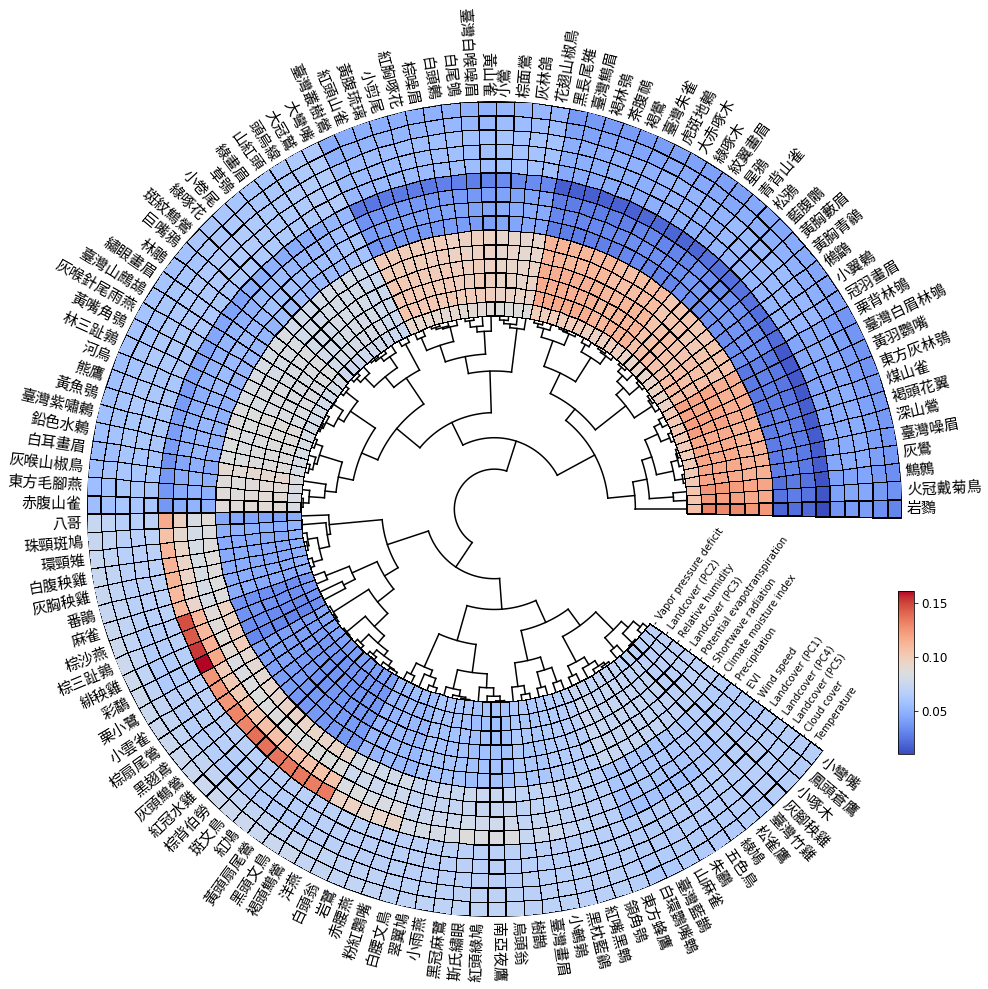

In [74]:
# 計算環境因子之間的相關性矩陣
correlation_matrix = df_attention_weight.corr()  # 使用皮爾森相關係數

# 將相關性矩陣轉換為距離矩陣
distance_matrix = 1 - correlation_matrix  # 相關性越高，距離越小

# 使用階層聚類得到環境因子的排序
linkage_env = linkage(squareform(distance_matrix), method='average')
dendro_env = dendrogram(linkage_env, labels=correlation_matrix.columns, no_plot=True)
ordered_env_factors = [correlation_matrix.columns[int(i)] for i in dendro_env['leaves']]

# 根據聚類結果重排環境因子順序
df_attention_weight = df_attention_weight[ordered_env_factors]  # 按照新順序重排 DataFrame 的列
env_factors = ordered_env_factors  # 更新環境因子名稱順序

# 設定數據
data = df_attention_weight.values
num_species, num_variables = data.shape
species_names = df_attention_weight.index  # 取得物種名稱列表
env_factors = df_attention_weight.columns  # 環境因子名稱

# 進行階層分群
linkage_matrix = linkage(df_attention_weight, method='ward')
dendro = dendrogram(linkage_matrix, labels=species_names, no_plot=True)
ordered_species = [species_names[int(i)] for i in dendro['leaves']]

# 根據分群順序重排 DataFrame
df_attention_weight = df_attention_weight.loc[ordered_species]
data = df_attention_weight.values  # 更新數據順序
species_names = df_attention_weight.index  # 更新物種名稱列表

# 設置極座標角度和半徑，並留出空白區域
theta = np.linspace(0, 2 * np.pi * (1 - 35/360), num_species, endpoint=False)  # 右側留出15度
radii = np.linspace(0.5, 1, num_variables)  # 定義不同的半徑層

# 創建極座標網格
theta, radii = np.meshgrid(theta, radii)

# 創建圖表和極坐標軸
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection='polar'))

# 去除極坐標的最外框
ax.spines['polar'].set_visible(False)
ax.grid(False)  # 關閉網格線條

# 使用 pcolormesh 在極坐標上繪製 heatmap
# c = ax.pcolormesh(theta, radii, data.T, cmap='coolwarm', shading='auto', edgecolors = (0, 0, 0, 0.1), linewidth = 0.1)
c = ax.pcolormesh(theta, radii, data.T, cmap='coolwarm', shading='auto', edgecolors = 'black', linewidth = 0.05)

# 添加物種名稱到圓外圍，調整左半圓物種名的旋轉方向
for i, name in enumerate(species_names):
#     name = f"{name.split('_')[0]} {name.split('_')[1]}"
    name = get_chinese_sciname(name)
    angle = theta[0, i]
    rotation = np.degrees(angle)
    if 90 <= rotation <= 270:  # 調整左半圓的物種名稱
        ax.text(angle, 1.03, name, ha='right', va='center', fontsize=15, rotation=rotation+180, rotation_mode='anchor', fontstyle = 'italic', fontproperties = font_prop)
    else:
        ax.text(angle, 1.03, name, ha='left', va='center', fontsize=15, rotation=rotation, rotation_mode='anchor', fontstyle = 'italic', fontproperties = font_prop)

# 添加環境因子名稱在右側空白區域
for j, env in enumerate(env_factors):
    ax.text(np.deg2rad(-37), 0.49 + j * (0.5 / (num_variables-1)), f'- {env}', ha='left', va='bottom', fontsize=10, rotation=55)


# 設置標題和隱藏軸標籤
ax.set_yticklabels([])  # 隱藏徑向標籤
ax.set_xticklabels([])  # 隱藏角度標籤


# 處理中間極座標的樹狀圖
icoord = dendro['icoord']  # x 座標
dcoord = dendro['dcoord']  # y 座標
dcoord_log = np.log10(np.array(dcoord)+1e-2)

angle_min = np.deg2rad(0)
angle_max = np.deg2rad(325)

x_min = np.array(icoord).min()
x_max = np.array(icoord).max()
delta = 10

icoord_polar = copy.deepcopy(icoord)
for i1, element1 in enumerate(icoord):
    for i2, element2 in enumerate(element1):
        icoord_polar[i1][i2] = (element2-x_min)/delta * (angle_max - angle_min) / (len(icoord)+1)

radius_min = 0.1
radius_max = 0.48

y_min = (np.array(dcoord_log)).min()
y_max = (np.array(dcoord_log)).max()

dcoord_polar = copy.deepcopy(dcoord_log)
for i1, element1 in enumerate(dcoord_log):
    for i2, element2 in enumerate(element1):
        dcoord_polar[i1][i2] = radius_max - (element2-y_min)/(y_max-y_min) * (radius_max - radius_min)

for (theta, radius) in zip(icoord_polar, dcoord_polar):
    ax.plot(theta[0:2], radius[0:2], color = 'black')
    ax.plot(theta[2:4], radius[2:4], color = 'black')
    theta_range = np.linspace(theta[1], theta[2], 100)
    ax.plot(theta_range, [radius[1]] * len(theta_range), color = 'black')


ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 - ax_pos.width * 0.005, 
                        ax_pos.y0 + ax_pos.height * 0.2, 
                        ax_pos.width * 0.02, 
                        ax_pos.height * 0.2])
cbar = fig.colorbar(c, ax = ax, cax = cbar_ax)
cbar.ax.tick_params(labelsize=12)  # 調整刻度標籤字體大小
# cbar.set_label('attention score', fontsize = 20)
    
# 儲存影像
# plt.savefig(os.path.join(plot_path_heatmap, 'attention_heatmap_org_circular_chinese.pdf'), dpi = 500, bbox_inches = 'tight', transparent = True, pad_inches = 0)

# 顯示圖表
plt.show()


### 物種名用英文

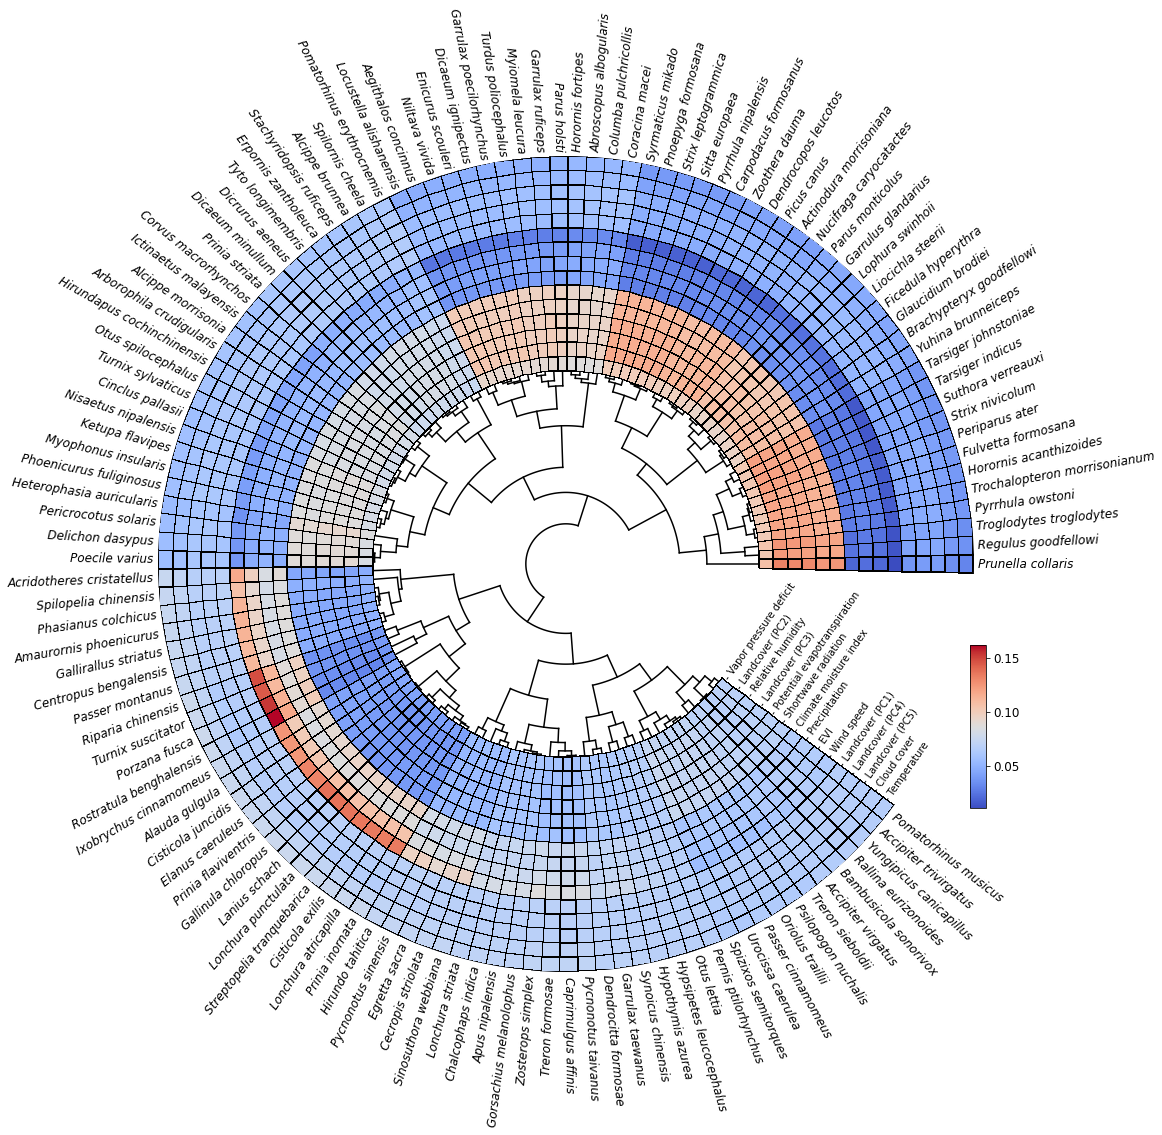

In [75]:
# 計算環境因子之間的相關性矩陣
correlation_matrix = df_attention_weight.corr()  # 使用皮爾森相關係數

# 將相關性矩陣轉換為距離矩陣
distance_matrix = 1 - correlation_matrix  # 相關性越高，距離越小

# 使用階層聚類得到環境因子的排序
linkage_env = linkage(squareform(distance_matrix), method='average')
dendro_env = dendrogram(linkage_env, labels=correlation_matrix.columns, no_plot=True)
ordered_env_factors = [correlation_matrix.columns[int(i)] for i in dendro_env['leaves']]

# 根據聚類結果重排環境因子順序
df_attention_weight = df_attention_weight[ordered_env_factors]  # 按照新順序重排 DataFrame 的列
env_factors = ordered_env_factors  # 更新環境因子名稱順序

# 設定數據
data = df_attention_weight.values
num_species, num_variables = data.shape
species_names = df_attention_weight.index  # 取得物種名稱列表
env_factors = df_attention_weight.columns  # 環境因子名稱

# 進行階層分群
linkage_matrix = linkage(df_attention_weight, method='ward')
dendro = dendrogram(linkage_matrix, labels=species_names, no_plot=True)
ordered_species = [species_names[int(i)] for i in dendro['leaves']]

# 根據分群順序重排 DataFrame
df_attention_weight = df_attention_weight.loc[ordered_species]
data = df_attention_weight.values  # 更新數據順序
species_names = df_attention_weight.index  # 更新物種名稱列表

# 設置極座標角度和半徑，並留出空白區域
theta = np.linspace(0, 2 * np.pi * (1 - 35/360), num_species, endpoint=False)  # 右側留出15度
radii = np.linspace(0.5, 1, num_variables)  # 定義不同的半徑層

# 創建極座標網格
theta, radii = np.meshgrid(theta, radii)

# 創建圖表和極坐標軸
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection='polar'))

# 去除極坐標的最外框
ax.spines['polar'].set_visible(False)
ax.grid(False)  # 關閉網格線條

# 使用 pcolormesh 在極坐標上繪製 heatmap
# c = ax.pcolormesh(theta, radii, data.T, cmap='coolwarm', shading='auto', edgecolors = (0, 0, 0, 0.1), linewidth = 0.1)
c = ax.pcolormesh(theta, radii, data.T, cmap='coolwarm', shading='auto', edgecolors = 'black', linewidth = 0.05)

# 添加物種名稱到圓外圍，調整左半圓物種名的旋轉方向
for i, name in enumerate(species_names):
    name = name.replace('_', ' ')
    angle = theta[0, i]
    rotation = np.degrees(angle)
    if 90 <= rotation <= 270:  # 調整左半圓的物種名稱
        ax.text(angle, 1.03, name, ha='right', va='center', fontsize=12, rotation=rotation+180, rotation_mode='anchor', fontstyle = 'italic')
    else:
        ax.text(angle, 1.03, name, ha='left', va='center', fontsize=12, rotation=rotation, rotation_mode='anchor', fontstyle = 'italic')

# 添加環境因子名稱在右側空白區域
for j, env in enumerate(env_factors):
    ax.text(np.deg2rad(-37), 0.49 + j * (0.5 / (num_variables-1)), f'- {env}', ha='left', va='bottom', fontsize=10, rotation=55)


# 設置標題和隱藏軸標籤
ax.set_yticklabels([])  # 隱藏徑向標籤
ax.set_xticklabels([])  # 隱藏角度標籤


# 處理中間極座標的樹狀圖
icoord = dendro['icoord']  # x 座標
dcoord = dendro['dcoord']  # y 座標
dcoord_log = np.log10(np.array(dcoord)+1e-2)

angle_min = np.deg2rad(0)
angle_max = np.deg2rad(325)

x_min = np.array(icoord).min()
x_max = np.array(icoord).max()
delta = 10

icoord_polar = copy.deepcopy(icoord)
for i1, element1 in enumerate(icoord):
    for i2, element2 in enumerate(element1):
        icoord_polar[i1][i2] = (element2-x_min)/delta * (angle_max - angle_min) / (len(icoord)+1)

radius_min = 0.1
radius_max = 0.48

y_min = (np.array(dcoord_log)).min()
y_max = (np.array(dcoord_log)).max()

dcoord_polar = copy.deepcopy(dcoord_log)
for i1, element1 in enumerate(dcoord_log):
    for i2, element2 in enumerate(element1):
        dcoord_polar[i1][i2] = radius_max - (element2-y_min)/(y_max-y_min) * (radius_max - radius_min)

for (theta, radius) in zip(icoord_polar, dcoord_polar):
    ax.plot(theta[0:2], radius[0:2], color = 'black')
    ax.plot(theta[2:4], radius[2:4], color = 'black')
    theta_range = np.linspace(theta[1], theta[2], 100)
    ax.plot(theta_range, [radius[1]] * len(theta_range), color = 'black')
    
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 - ax_pos.width * 0.005, 
                        ax_pos.y0 + ax_pos.height * 0.2, 
                        ax_pos.width * 0.02, 
                        ax_pos.height * 0.2])
cbar = fig.colorbar(c, ax = ax, cax = cbar_ax)
cbar.ax.tick_params(labelsize=12)  # 調整刻度標籤字體大小
# cbar.set_label('attention score', fontsize = 20)

# 儲存影像
# plt.savefig(os.path.join(plot_path_heatmap, 'attention_heatmap_org_circular.pdf'), dpi = 500, bbox_inches = 'tight', transparent = True, pad_inches = 0)

# 顯示圖表
plt.show()


### 做過標準化的 attention score 所畫的 heatmap

### 英文

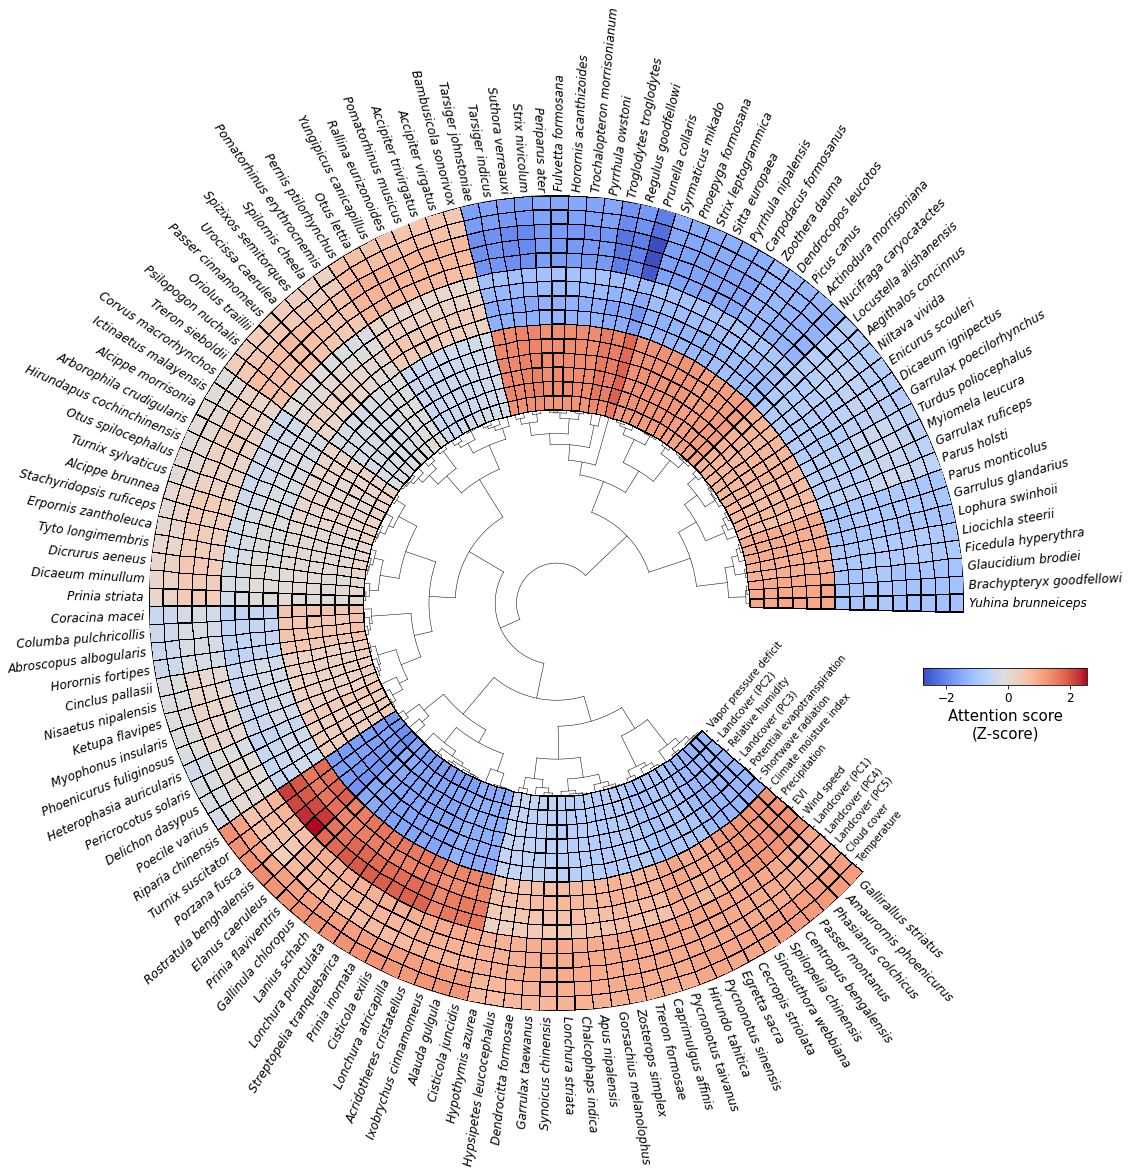

In [76]:
# 計算環境因子之間的相關性矩陣
correlation_matrix = df_attention_weight_standard.corr()  # 使用皮爾森相關係數

# 將相關性矩陣轉換為距離矩陣
distance_matrix = 1 - correlation_matrix  # 相關性越高，距離越小

# 使用階層聚類得到環境因子的排序
linkage_env = linkage(squareform(distance_matrix), method='average')
dendro_env = dendrogram(linkage_env, labels=correlation_matrix.columns, no_plot=True)
ordered_env_factors = [correlation_matrix.columns[int(i)] for i in dendro_env['leaves']]

# 根據聚類結果重排環境因子順序
df_attention_weight_standard = df_attention_weight_standard[ordered_env_factors]  # 按照新順序重排 DataFrame 的列
env_factors = ordered_env_factors  # 更新環境因子名稱順序

# 設定數據
data = df_attention_weight_standard.values
num_species, num_variables = data.shape
species_names = df_attention_weight_standard.index  # 取得物種名稱列表
env_factors = df_attention_weight_standard.columns  # 環境因子名稱

# 進行階層分群
linkage_matrix = linkage(df_attention_weight_standard, method='ward')
dendro = dendrogram(linkage_matrix, labels=species_names, no_plot=True)
ordered_species = [species_names[int(i)] for i in dendro['leaves']]

# 根據分群順序重排 DataFrame
df_attention_weight_standard = df_attention_weight_standard.loc[ordered_species]
data = df_attention_weight_standard.values  # 更新數據順序
species_names = df_attention_weight_standard.index  # 更新物種名稱列表

# 設置極座標角度和半徑，並留出空白區域
theta = np.linspace(0, 2 * np.pi * (1 - 40/360), num_species, endpoint=False)  # 右側留出15度
radii = np.linspace(0.5, 1, num_variables)  # 定義不同的半徑層

# 創建極座標網格
theta, radii = np.meshgrid(theta, radii)

# 創建圖表和極坐標軸
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection='polar'))

ax.grid(False)  # 關閉網格線條

# 去除極坐標的最外框
ax.spines['polar'].set_visible(False)

# 使用 pcolormesh 在極坐標上繪製 heatmap
# c = ax.pcolormesh(theta, radii, data.T, cmap='coolwarm', shading='auto', edgecolors = (0, 0, 0, 0.1), linewidth = 0.1)
c = ax.pcolormesh(theta, radii, data.T, cmap='coolwarm', shading='auto', edgecolors = 'black', linewidth = 0.05)

# 添加物種名稱到圓外圍，調整左半圓物種名的旋轉方向
for i, name in enumerate(species_names):
    name = f"{name.split('_')[0]} {name.split('_')[1]}"
    angle = theta[0, i]
    rotation = np.degrees(angle)
    if 90 <= rotation <= 270:  # 調整左半圓的物種名稱
        ax.text(angle, 1.03, name, ha='right', va='center', fontsize=12, rotation=rotation+180, rotation_mode='anchor', fontstyle = 'italic')
    else:
        ax.text(angle, 1.03, name, ha='left', va='center', fontsize=12, rotation=rotation, rotation_mode='anchor', fontstyle = 'italic')

# 添加環境因子名稱在右側空白區域
for j, env in enumerate(env_factors):
    ax.text(np.deg2rad(-42), 0.49 + j * (0.5 / (num_variables-1)), f'- {env}', ha='left', va='bottom', fontsize=10, rotation=50)


# 設置標題和隱藏軸標籤
ax.set_yticklabels([])  # 隱藏徑向標籤
ax.set_xticklabels([])  # 隱藏角度標籤


# 處理中間極座標的樹狀圖
icoord = dendro['icoord']  # x 座標
dcoord = dendro['dcoord']  # y 座標
dcoord_log = np.log10(np.array(dcoord)+1)

angle_min = np.deg2rad(0)
angle_max = np.deg2rad(320)

x_min = np.array(icoord).min()
x_max = np.array(icoord).max()
delta = 10

icoord_polar = copy.deepcopy(icoord)
for i1, element1 in enumerate(icoord):
    for i2, element2 in enumerate(element1):
        icoord_polar[i1][i2] = (element2-x_min)/delta * (angle_max - angle_min) / (len(icoord)+1)

radius_min = 0.1
radius_max = 0.48

y_min = (np.array(dcoord_log)).min()
y_max = (np.array(dcoord_log)).max()

dcoord_polar = copy.deepcopy(dcoord_log)
for i1, element1 in enumerate(dcoord_log):
    for i2, element2 in enumerate(element1):
        dcoord_polar[i1][i2] = radius_max - (element2-y_min)/(y_max-y_min) * (radius_max - radius_min)

for (theta, radius) in zip(icoord_polar, dcoord_polar):
    ax.plot(theta[0:2], radius[0:2], color = 'black', linewidth = 0.5)
    ax.plot(theta[2:4], radius[2:4], color = 'black', linewidth = 0.5)
    theta_range = np.linspace(theta[1], theta[2], 100)
    ax.plot(theta_range, [radius[1]] * len(theta_range), color = 'black', linewidth = 0.5)
    
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 - ax_pos.width * 0.05, 
                        ax_pos.y0 + ax_pos.height * 0.4, 
                        ax_pos.width * 0.2, 
                        ax_pos.height * 0.02])
cbar = fig.colorbar(c, ax = ax, cax = cbar_ax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=12)  # 調整刻度標籤字體大小
cbar.set_label('Attention score\n(Z-score)', fontsize = 15)

# 儲存影像
# plt.savefig(os.path.join(plot_path_heatmap, 'attention_heatmap_circular_standard.pdf'), dpi = 500, bbox_inches = 'tight', transparent = True, pad_inches = 0)

# 顯示圖表
plt.show()


### 中文

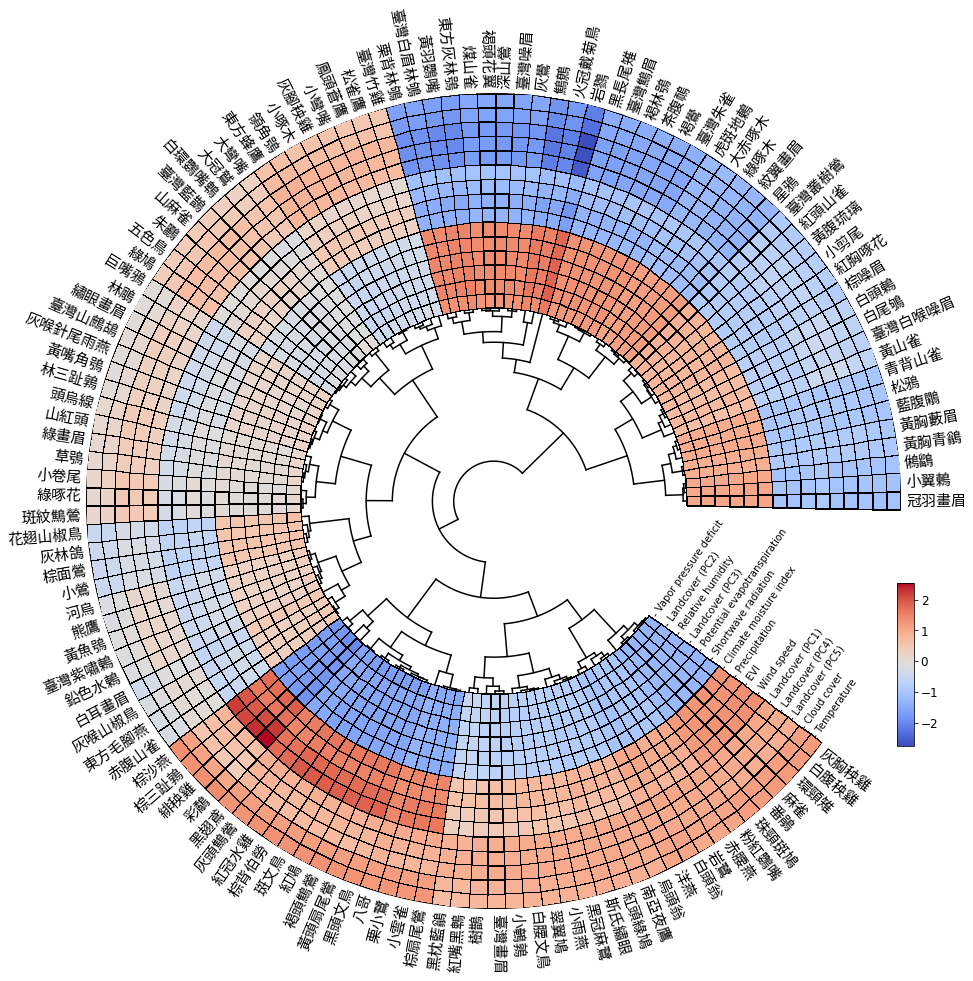

In [77]:
# 計算環境因子之間的相關性矩陣
correlation_matrix = df_attention_weight_standard.corr()  # 使用皮爾森相關係數

# 將相關性矩陣轉換為距離矩陣
distance_matrix = 1 - correlation_matrix  # 相關性越高，距離越小

# 使用階層聚類得到環境因子的排序
linkage_env = linkage(squareform(distance_matrix), method='average')
dendro_env = dendrogram(linkage_env, labels=correlation_matrix.columns, no_plot=True)
ordered_env_factors = [correlation_matrix.columns[int(i)] for i in dendro_env['leaves']]

# 根據聚類結果重排環境因子順序
df_attention_weight_standard = df_attention_weight_standard[ordered_env_factors]  # 按照新順序重排 DataFrame 的列
env_factors = ordered_env_factors  # 更新環境因子名稱順序

# 設定數據
data = df_attention_weight_standard.values
num_species, num_variables = data.shape
species_names = df_attention_weight_standard.index  # 取得物種名稱列表
env_factors = df_attention_weight_standard.columns  # 環境因子名稱

# 進行階層分群
linkage_matrix = linkage(df_attention_weight_standard, method='ward')
dendro = dendrogram(linkage_matrix, labels=species_names, no_plot=True)
ordered_species = [species_names[int(i)] for i in dendro['leaves']]

# 根據分群順序重排 DataFrame
df_attention_weight_standard = df_attention_weight_standard.loc[ordered_species]
data = df_attention_weight_standard.values  # 更新數據順序
species_names = df_attention_weight_standard.index  # 更新物種名稱列表

# 設置極座標角度和半徑，並留出空白區域
theta = np.linspace(0, 2 * np.pi * (1 - 35/360), num_species, endpoint=False)  # 右側留出15度
radii = np.linspace(0.5, 1, num_variables)  # 定義不同的半徑層

# 創建極座標網格
theta, radii = np.meshgrid(theta, radii)

# 創建圖表和極坐標軸
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection='polar'))

ax.grid(False)  # 關閉網格線條

# 去除極坐標的最外框
ax.spines['polar'].set_visible(False)

# 使用 pcolormesh 在極坐標上繪製 heatmap
# c = ax.pcolormesh(theta, radii, data.T, cmap='coolwarm', shading='auto', edgecolors = (0, 0, 0, 0.1), linewidth = 0.1)
c = ax.pcolormesh(theta, radii, data.T, cmap='coolwarm', shading='auto', edgecolors = 'black', linewidth = 0.05)

# 添加物種名稱到圓外圍，調整左半圓物種名的旋轉方向
for i, name in enumerate(species_names):
    name = get_chinese_sciname(name)
    angle = theta[0, i]
    rotation = np.degrees(angle)
    if 90 <= rotation <= 270:  # 調整左半圓的物種名稱
        ax.text(angle, 1.03, name, ha='right', va='center', fontsize=15, rotation=rotation+180, rotation_mode='anchor', fontstyle = 'italic', fontproperties = font_prop)
    else:
        ax.text(angle, 1.03, name, ha='left', va='center', fontsize=15, rotation=rotation, rotation_mode='anchor', fontstyle = 'italic', fontproperties = font_prop)

# 添加環境因子名稱在右側空白區域
for j, env in enumerate(env_factors):
    ax.text(np.deg2rad(-37), 0.49 + j * (0.5 / (num_variables-1)), f'- {env}', ha='left', va='bottom', fontsize=10, rotation=55)


# 設置標題和隱藏軸標籤
ax.set_yticklabels([])  # 隱藏徑向標籤
ax.set_xticklabels([])  # 隱藏角度標籤


# 處理中間極座標的樹狀圖
icoord = dendro['icoord']  # x 座標
dcoord = dendro['dcoord']  # y 座標
dcoord_log = np.log10(np.array(dcoord)+1)

angle_min = np.deg2rad(0)
angle_max = np.deg2rad(325)

x_min = np.array(icoord).min()
x_max = np.array(icoord).max()
delta = 10

icoord_polar = copy.deepcopy(icoord)
for i1, element1 in enumerate(icoord):
    for i2, element2 in enumerate(element1):
        icoord_polar[i1][i2] = (element2-x_min)/delta * (angle_max - angle_min) / (len(icoord)+1)

radius_min = 0.1
radius_max = 0.48

y_min = (np.array(dcoord_log)).min()
y_max = (np.array(dcoord_log)).max()

dcoord_polar = copy.deepcopy(dcoord_log)
for i1, element1 in enumerate(dcoord_log):
    for i2, element2 in enumerate(element1):
        dcoord_polar[i1][i2] = radius_max - (element2-y_min)/(y_max-y_min) * (radius_max - radius_min)

for (theta, radius) in zip(icoord_polar, dcoord_polar):
    ax.plot(theta[0:2], radius[0:2], color = 'black')
    ax.plot(theta[2:4], radius[2:4], color = 'black')
    theta_range = np.linspace(theta[1], theta[2], 100)
    ax.plot(theta_range, [radius[1]] * len(theta_range), color = 'black')
    
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 - ax_pos.width * 0.005, 
                        ax_pos.y0 + ax_pos.height * 0.2, 
                        ax_pos.width * 0.02, 
                        ax_pos.height * 0.2])
cbar = fig.colorbar(c, ax = ax, cax = cbar_ax)
cbar.ax.tick_params(labelsize=12)  # 調整刻度標籤字體大小
# cbar.set_label('attention score', fontsize = 20)

# 儲存影像
# plt.savefig(os.path.join(plot_path_heatmap, 'attention_heatmap_circular_standard_chinese.pdf'), dpi = 500, bbox_inches = 'tight', transparent = True, pad_inches = 0)

# 顯示圖表
plt.show()


# 測試區，勿刪

In [32]:
x_coo = []
for i, d in enumerate(dendro['dcoord']):
    if d[0] == 0:
        print(dendro['icoord'][i][0])
        x_coo.append(dendro['icoord'][i][0])
    if d[3] == 0:
        print(dendro['icoord'][i][3])
        x_coo.append(dendro['icoord'][i][3])

15.0
25.0
5.0
35.0
45.0
65.0
75.0
55.0
95.0
105.0
85.0
125.0
135.0
145.0
155.0
175.0
185.0
165.0
195.0
205.0
215.0
225.0
115.0
255.0
265.0
245.0
235.0
295.0
305.0
285.0
275.0
325.0
335.0
315.0
355.0
365.0
345.0
395.0
405.0
385.0
375.0
415.0
425.0
435.0
445.0
475.0
485.0
465.0
455.0
495.0
505.0
515.0
525.0
535.0
545.0
555.0
565.0
595.0
605.0
585.0
575.0
615.0
625.0
645.0
655.0
635.0
685.0
695.0
675.0
665.0
705.0
715.0
725.0
735.0
755.0
765.0
745.0
795.0
805.0
785.0
775.0
825.0
835.0
815.0
865.0
875.0
855.0
845.0
895.0
905.0
885.0
915.0
925.0
935.0
945.0
955.0
965.0
985.0
995.0
975.0
1005.0
1015.0
1035.0
1045.0
1025.0
1075.0
1085.0
1065.0
1055.0
1115.0
1125.0
1105.0
1095.0
1135.0
1145.0
1165.0
1175.0
1155.0
1215.0
1225.0
1205.0
1235.0
1245.0
1195.0
1185.0


In [33]:
icoord = dendro['icoord']  # x 座標
dcoord = dendro['dcoord']  # y 座標
dcoord_log = np.log10(np.array(dcoord)+1)

angle_min = np.deg2rad(0)
angle_max = np.deg2rad(325)

x_min = np.array(icoord).min()
x_max = np.array(icoord).max()
delta = 10

icoord_polar = copy.deepcopy(icoord)
for i1, element1 in enumerate(icoord):
    for i2, element2 in enumerate(element1):
        icoord_polar[i1][i2] = (element2-x_min)/delta * (angle_max - angle_min) / (len(icoord)+1)


radius_min = 0.1
radius_max = 0.45

y_min = (np.array(dcoord_log)).min()
y_max = (np.array(dcoord_log)).max()

dcoord_polar = copy.deepcopy(dcoord_log)
for i1, element1 in enumerate(dcoord_log):
    for i2, element2 in enumerate(element1):
        dcoord_polar[i1][i2] = radius_max - (element2-y_min)/(y_max-y_min) * (radius_max - radius_min)


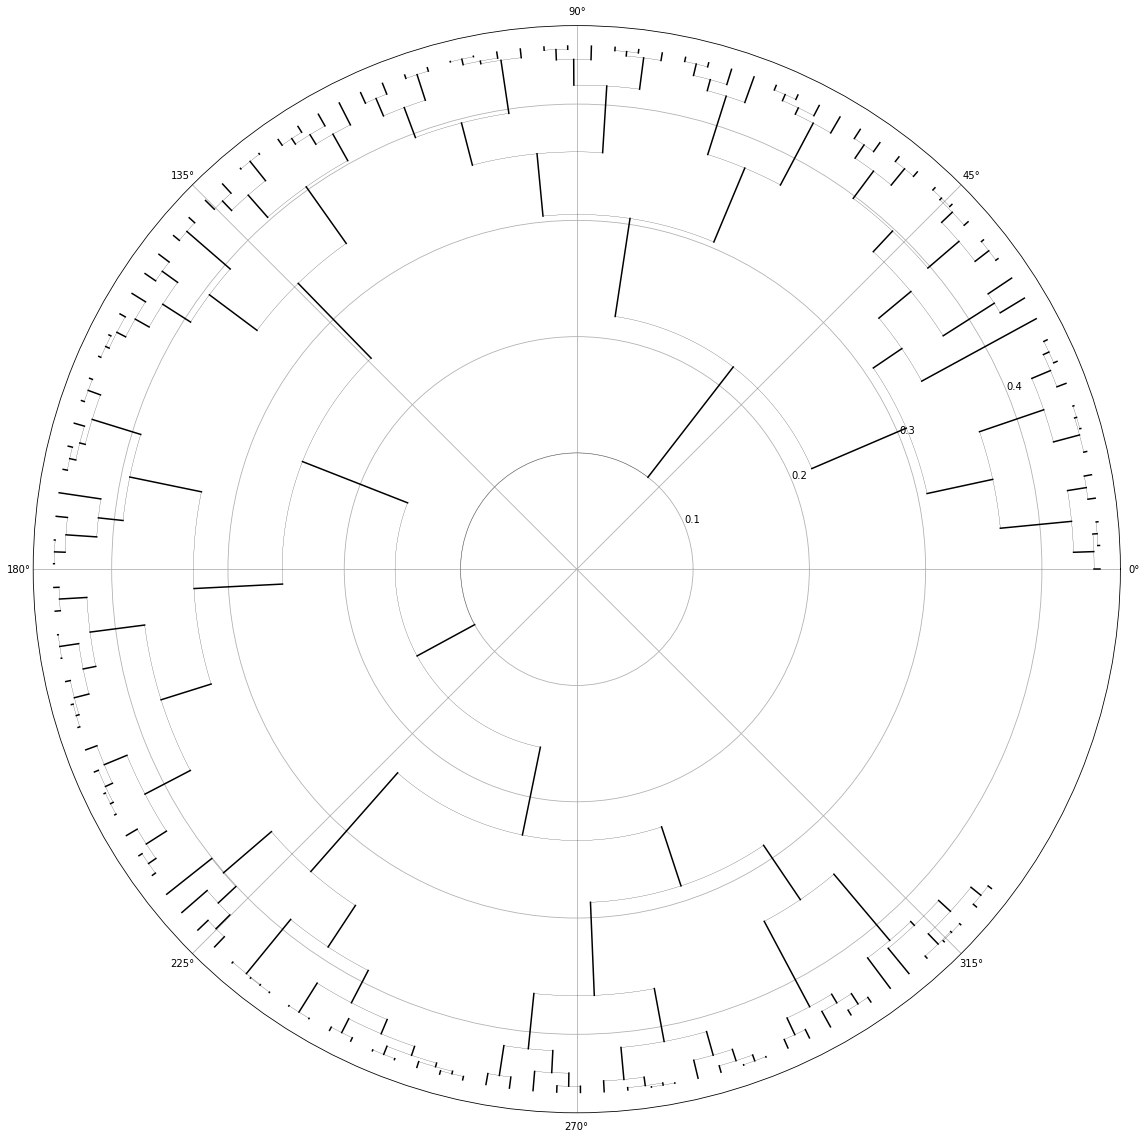

In [34]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (20, 20))

for (theta, radius) in zip(icoord_polar, dcoord_polar):
    ax.plot(theta[0:2], radius[0:2], color = 'black')
    ax.plot(theta[2:4], radius[2:4], color = 'black')
    theta_range = np.linspace(theta[1], theta[2], 100)
    ax.plot(theta_range, [radius[1]] * len(theta_range), color = 'black', linewidth = 0.2)


# 排序各個環境因子的權重

In [78]:
df_attention_weight.sum().sort_values()

Climate moisture index          7.118331
Precipitation                   7.131971
Temperature                     7.300266
EVI                             7.347712
Cloud cover                     7.381248
Wind speed                      7.385471
Landcover (PC1)                 7.457442
Landcover (PC4)                 7.514810
Landcover (PC5)                 7.528430
Vapor pressure deficit          9.336657
Potential evapotranspiration    9.811626
Shortwave radiation             9.818802
Landcover (PC3)                 9.923989
Relative humidity               9.945919
Landcover (PC2)                 9.997327
dtype: float64

# 海拔

In [79]:
species_occ = pd.read_csv(DeepSDM_conf.cooccurrence_conf['sp_filter_from'])

In [80]:
# 初始化物種平均海拔字典
species_avg_elevation = {}
species_std_elevation = {}

# 讀取海拔數據
elev_path = os.path.join(env_info['dir_base'], env_info['info']['elev'][date_list_train[0]]['tif_span_avg'])
with rasterio.open(elev_path, 'r') as f:
    elev_rst = f.read(1)  # 海拔數據

# 為每個物種計算平均海拔
for i, sp in enumerate(species_list_predict):
    print(f'\r{i+1}/{len(species_list_predict)} {sp}', end='')
    # 過濾出當前物種的出現記錄
    occ_sp = species_occ[species_occ.species == sp]

    # 將緯經度轉換為影像索引
    rows, cols = rasterio.transform.rowcol(
        transform,
        occ_sp['decimalLongitude'].values,
        occ_sp['decimalLatitude'].values
    )

    # 獲取對應位置的海拔值
    elevations = elev_rst[rows, cols]

    # 過濾無效海拔數據（如 -9999 值）
    valid_elevations = np.where(elevations == -9999, np.nan, elevations)

    # 計算平均和標準差
    if len(valid_elevations) > 0:
        species_avg_elevation[sp] = np.nanmean(valid_elevations)
        species_std_elevation[sp] = np.nanstd(valid_elevations)
    else:
        species_avg_elevation[sp] = None  # 如果沒有有效數據，設置為 None
        species_std_elevation[sp] = None

# 合併平均值和標準差到同一個 DataFrame
elevation_df = pd.DataFrame({
    'Species': list(species_avg_elevation.keys()),
    'AverageElevation': list(species_avg_elevation.values()),
    'StdElevation': list(species_std_elevation.values())
})

# 輸出結果
print(elevation_df)


125/125 Zosterops_simplexpillusianum                       Species  AverageElevation  StdElevation
0       Abroscopus_albogularis       1391.549805    572.731934
1        Accipiter_trivirgatus        287.942932    416.868774
2           Accipiter_virgatus        427.538818    589.251099
3    Acridotheres_cristatellus         45.512520    106.316483
4      Actinodura_morrisoniana       2019.975952    446.814606
..                         ...               ...           ...
120          Urocissa_caerulea        258.378876    299.289001
121         Yuhina_brunneiceps       1752.611206    604.680176
122    Yungipicus_canicapillus        408.490295    459.109283
123             Zoothera_dauma       1543.271606    673.078064
124          Zosterops_simplex        200.117386    316.082733

[125 rows x 3 columns]


In [81]:
elevation_df['Temperature_attention'] = df_attention_weight.Temperature[elevation_df.Species].tolist()

SignificanceResult(statistic=-0.6603072196620583, pvalue=5.437156918655867e-17)
PearsonRResult(statistic=-0.6384008600632124, pvalue=1.158569752377338e-15)


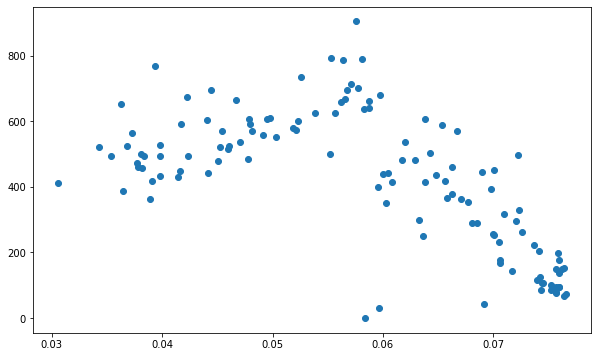

In [82]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = elevation_df.Temperature_attention, 
           y = elevation_df.StdElevation)

print(scipy.stats.spearmanr(elevation_df.Temperature_attention, elevation_df.StdElevation))
print(scipy.stats.pearsonr(elevation_df.Temperature_attention, elevation_df.StdElevation))

In [83]:
elevation_df.Species[np.argsort(elevation_df.StdElevation)[::-1]]

24           Corvus_macrorhynchos
25               Delichon_dasypus
46     Hirundapus_cochinchinensis
65            Nisaetus_nipalensis
105           Strix_leptogrammica
                  ...            
97        Rostratula_benghalensis
84                  Porzana_fusca
108            Synoicus_chinensis
119             Tyto_longimembris
118             Turnix_sylvaticus
Name: Species, Length: 125, dtype: object

In [ ]:
# 進行 Yeo-Johnson 轉換
transformed_x, lambda_optimal = yeojohnson(temp_attention)

# 創建圖形
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=transformed_x, y=elev_std, c = 'black')

# 設置 x 軸標籤
ax.set_xlabel('Attention score (temperature)', size = 15)
ax.set_ylabel('Elevation standard deviation (m)', size = 15)

# 設置 x 軸的 ticks 為轉換後的位置，但標籤為原始的 temp_attention 值
tick_orig = [0.01, 0.02, 0.04, 0.06, 0.08, 0.12]
tick_trans = yeojohnson(tick_orig, lmbda=lambda_optimal)
ax.set_xticks(tick_trans)
ax.set_xticklabels([f'{val:.02f}' for val in tick_orig], size = 12)
ax.tick_params(axis='y', labelsize=12)
# 顯示的x最小值與最大值
ax.set_xlim(transformed_x.min()-0.001, transformed_x.max()+0.001)

# log image 
# plt.savefig(os.path.join(plot_path_heatmap, 'attentionscore_elevstd.pdf'), dpi = 200, bbox_inches = 'tight', transparent = True)

# 顯示圖形
plt.show()

print(scipy.stats.spearmanr(temp_attention, elev_std))
print(scipy.stats.pearsonr(temp_attention, elev_std))

In [ ]:
fig, ax = plt.subplots(figsize = (20, 6))
ax.scatter(x = elevation_df.Species[np.argsort(elevation_df.Temperature_attention)], 
           y = elevation_df.StdElevation[np.argsort(elevation_df.Temperature_attention)])
plt.setp(ax.get_xticklabels(), rotation=270)

print(scipy.stats.spearmanr(elev_std[np.argsort(temp_attention)], range(len(elev_std))))
print(scipy.stats.pearsonr(elev_std[np.argsort(temp_attention)], range(len(elev_std))))

SignificanceResult(statistic=-0.952995391705069, pvalue=1.2343132292629747e-65)
PearsonRResult(statistic=-0.9558666110533522, pvalue=2.7920955489894552e-67)


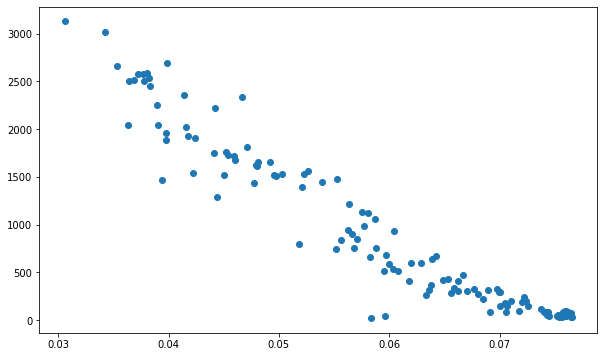

In [84]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = elevation_df.Temperature_attention, 
           y = elevation_df.AverageElevation)

print(scipy.stats.spearmanr(elevation_df.Temperature_attention, elevation_df.AverageElevation))
print(scipy.stats.pearsonr(elevation_df.Temperature_attention, elevation_df.AverageElevation))

In [ ]:
# 創建圖形
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=transformed_x, y=elev_mean, c = 'black')

# 設置 x 軸標籤
ax.set_xlabel('Attention score (temperature)', size = 15)
ax.set_ylabel('Elevation mean (m)', size = 15)

# 設置 x 軸的 ticks 為轉換後的位置，但標籤為原始的 temp_attention 值
tick_orig = [0.01, 0.02, 0.04, 0.06, 0.08, 0.12]
tick_trans = yeojohnson(tick_orig, lmbda=lambda_optimal)
ax.set_xticks(tick_trans)
ax.set_xticklabels([f'{val:.02f}' for val in tick_orig], size = 12)
ax.tick_params(axis='y', labelsize=12)
# 顯示的x最小值與最大值
ax.set_xlim(transformed_x.min()-0.001, transformed_x.max()+0.001)

# log image 
# plt.savefig(os.path.join(plot_path_heatmap, 'attentionscore_elevmean.pdf'), dpi = 200, bbox_inches = 'tight', transparent = True)

# 顯示圖形
plt.show()

print(scipy.stats.spearmanr(temp_attention, elev_mean))
print(scipy.stats.pearsonr(temp_attention, elev_mean))

In [ ]:
fig, ax = plt.subplots(figsize = (20, 6))
ax.scatter(x = elevation_df.Species[np.argsort(elevation_df.Temperature_attention)], 
           y = elevation_df.AverageElevation[np.argsort(elevation_df.Temperature_attention)])
plt.setp(ax.get_xticklabels(), rotation=270)

print(scipy.stats.spearmanr(elev_std[np.argsort(temp_attention)], range(len(elev_std))))
print(scipy.stats.pearsonr(elev_std[np.argsort(temp_attention)], range(len(elev_std))))

# 溫度

In [85]:
# 初始化物種平均溫度字典
species_avg_temp = {}
species_std_temp = {}

# 確保 month 和 year 是數字類型
species_occ['month'] = species_occ['month'].astype(int)
species_occ['year'] = species_occ['year'].astype(int)

# 為每個物種計算平均溫度
for i_sp, sp in enumerate(species_list_predict):
    print(f'\r{i_sp+1}/{len(species_list_predict)} {sp}', end='')
    # 過濾出當前物種的出現記錄
    occ_sp = species_occ[species_occ.species == sp]
    
    sp_temp = []  # 初始化為空列表
    
    for i_date, date in enumerate(date_list_predict):
        # 讀取溫度影像
        temp_path = os.path.join(env_info['dir_base'], env_info['info']['tas'][date]['tif_span_avg'])
        with rasterio.open(temp_path, 'r') as f:
            temp_rst = f.read(1)

        # 過濾出符合日期的出現記錄
        occ_sp_date = occ_sp[(occ_sp.month == int(date.split('-')[1])) & (occ_sp.year == int(date.split('-')[0]))]
        
        if occ_sp_date.empty:
            continue

        # 將緯經度轉換為影像索引
        rows, cols = rasterio.transform.rowcol(
            transform,
            occ_sp_date['decimalLongitude'].values,
            occ_sp_date['decimalLatitude'].values
        )

        # 獲取對應位置的溫度值
        temps = temp_rst[rows, cols]

        # 過濾無效溫度數據（如 -9999 值）
        valid_temps = temps.copy()
        valid_temps[temps == -9999] = np.nan
        
        # 存入 sp_temp
        sp_temp.extend(valid_temps / 10 - 273.15)

    # 計算平均和標準差
    if len(sp_temp) > 0:
        species_avg_temp[sp] = np.nanmean(sp_temp)
        species_std_temp[sp] = np.nanstd(sp_temp)
    else:
        species_avg_temp[sp] = None  # 如果沒有有效數據，設置為 None
        species_std_temp[sp] = None
        
# 合併平均值和標準差到同一個 DataFrame
temp_df = pd.DataFrame({
    'Species': list(species_avg_temp.keys()),
    'AverageTemperature': list(species_avg_temp.values()),
    'StdTemperature': list(species_std_temp.values())
})

# 輸出結果
print(temp_df)


125/125 Zosterops_simplexpillusianum                       Species  AverageTemperature  StdTemperature
0       Abroscopus_albogularis           17.246010        4.358515
1        Accipiter_trivirgatus           21.636414        4.457835
2           Accipiter_virgatus           20.918360        4.733036
3    Acridotheres_cristatellus           21.932838        4.445347
4      Actinodura_morrisoniana           13.258317        4.148411
..                         ...                 ...             ...
120          Urocissa_caerulea           21.126705        4.424074
121         Yuhina_brunneiceps           15.382707        3.912969
122    Yungipicus_canicapillus           21.418785        4.395624
123             Zoothera_dauma           17.411053        5.114944
124          Zosterops_simplex           22.718266        4.134151

[125 rows x 3 columns]


In [86]:
temp_df['Temperature_attention'] = df_attention_weight.Temperature[temp_df.Species].tolist()

SignificanceResult(statistic=0.07571121351766512, pvalue=0.40136915867426093)
PearsonRResult(statistic=0.03807603665503216, pvalue=0.6733321736067606)


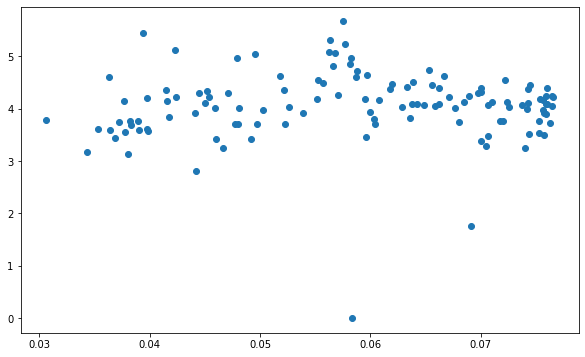

In [87]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = temp_df.Temperature_attention, 
           y = temp_df.StdTemperature)

print(scipy.stats.spearmanr(temp_df.Temperature_attention, temp_df.StdTemperature))
print(scipy.stats.pearsonr(temp_df.Temperature_attention, temp_df.StdTemperature))

SignificanceResult(statistic=0.93458064516129, pvalue=4.742544141514443e-57)
PearsonRResult(statistic=0.9325099698826763, pvalue=3.0245146163986044e-56)


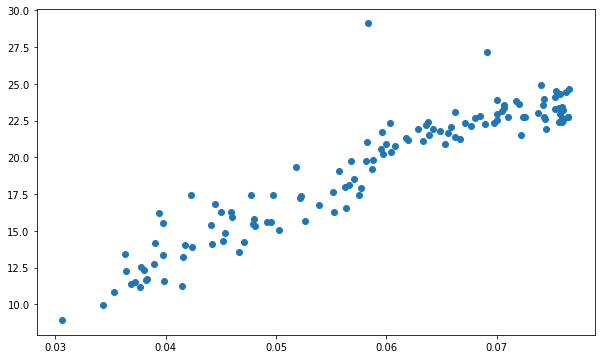

In [88]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = temp_df.Temperature_attention, 
           y = temp_df.AverageTemperature)

print(scipy.stats.spearmanr(temp_df.Temperature_attention, temp_df.AverageTemperature))
print(scipy.stats.pearsonr(temp_df.Temperature_attention, temp_df.AverageTemperature))

# 雨量

In [89]:
# 初始化物種平均溫度字典
species_avg_prec = {}
species_std_prec = {}

# 確保 month 和 year 是數字類型
species_occ['month'] = species_occ['month'].astype(int)
species_occ['year'] = species_occ['year'].astype(int)

# 為每個物種計算平均溫度
for i_sp, sp in enumerate(species_list_predict):
    print(f'\r{i_sp+1}/{len(species_list_predict)} {sp}', end='')
    # 過濾出當前物種的出現記錄
    occ_sp = species_occ[species_occ.species == sp]
    
    sp_prec = []  # 初始化為空列表
    
    for i_date, date in enumerate(date_list_predict):
        # 讀取溫度影像
        prec_path = os.path.join(env_info['dir_base'], env_info['info']['pr'][date]['tif_span_avg'])
        with rasterio.open(prec_path, 'r') as f:
            prec_rst = f.read(1)

        # 過濾出符合日期的出現記錄
        occ_sp_date = occ_sp[(occ_sp.month == int(date.split('-')[1])) & (occ_sp.year == int(date.split('-')[0]))]
        
        if occ_sp_date.empty:
            continue

        # 將緯經度轉換為影像索引
        rows, cols = rasterio.transform.rowcol(
            transform,
            occ_sp_date['decimalLongitude'].values,
            occ_sp_date['decimalLatitude'].values
        )

        # 獲取對應位置的溫度值
        precs = prec_rst[rows, cols]

        # 過濾無效溫度數據（如 -9999 值）
        valid_precs = precs.copy()
        valid_precs[precs == -9999] = np.nan
        
        # 存入 sp_prec
        sp_prec.extend(valid_precs)

    # 計算平均和標準差
    if len(sp_prec) > 0:
        species_avg_prec[sp] = np.nanmean(sp_prec)
        species_std_prec[sp] = np.nanstd(sp_prec)
    else:
        species_avg_prec[sp] = None  # 如果沒有有效數據，設置為 None
        species_std_prec[sp] = None
        
# 合併平均值和標準差到同一個 DataFrame
prec_df = pd.DataFrame({
    'Species': list(species_avg_prec.keys()),
    'Averageprecipitation': list(species_avg_prec.values()),
    'Stdprecipitation': list(species_std_prec.values())
})

# 輸出結果
print(prec_df)


125/125 Zosterops_simplexpillusianum                       Species  Averageprecipitation  Stdprecipitation
0       Abroscopus_albogularis          22726.101562      22239.617188
1        Accipiter_trivirgatus          20490.996094      20705.962891
2           Accipiter_virgatus          21771.408203      21415.708984
3    Acridotheres_cristatellus          21476.744141      15817.766602
4      Actinodura_morrisoniana          22266.919922      23936.769531
..                         ...                   ...               ...
120          Urocissa_caerulea          25176.041016      17283.931641
121         Yuhina_brunneiceps          24120.285156      22600.203125
122    Yungipicus_canicapillus          17416.343750      20450.902344
123             Zoothera_dauma          33794.175781      28075.337891
124          Zosterops_simplex          20297.070312      19997.839844

[125 rows x 3 columns]


In [90]:
prec_df['Precipitation_attention'] = df_attention_weight.Precipitation[prec_df.Species].tolist()

SignificanceResult(statistic=-0.3139354838709677, pvalue=0.0003635574495947023)
PearsonRResult(statistic=-0.28343686709446475, pvalue=0.0013598746813807928)


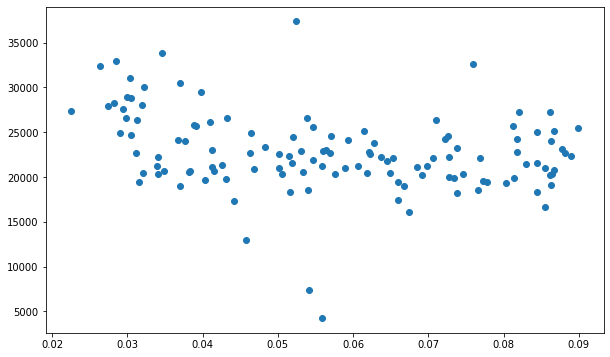

In [91]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = prec_df.Precipitation_attention, 
           y = prec_df.Averageprecipitation)

print(scipy.stats.spearmanr(prec_df.Precipitation_attention, prec_df.Averageprecipitation))
print(scipy.stats.pearsonr(prec_df.Precipitation_attention, prec_df.Averageprecipitation))

SignificanceResult(statistic=-0.2023471582181259, pvalue=0.023632884086225377)
PearsonRResult(statistic=-0.09922928439885921, pvalue=0.270900407151096)


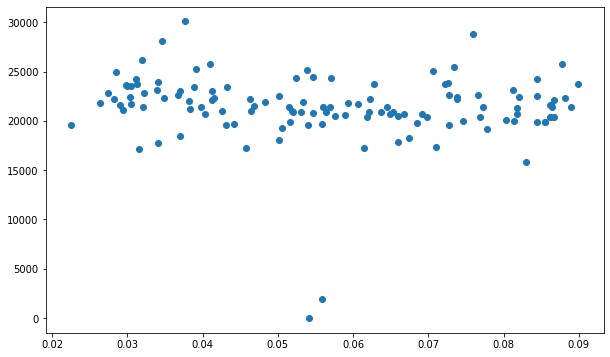

In [92]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = prec_df.Precipitation_attention, 
           y = prec_df.Stdprecipitation)

print(scipy.stats.spearmanr(prec_df.Precipitation_attention, prec_df.Stdprecipitation))
print(scipy.stats.pearsonr(prec_df.Precipitation_attention, prec_df.Stdprecipitation))

# Landcover PC2

In [93]:
# 初始化物種平均溫度字典
species_avg_landcoverPC2 = {}
species_std_landcoverPC2 = {}

# 確保 month 和 year 是數字類型
species_occ['month'] = species_occ['month'].astype(int)
species_occ['year'] = species_occ['year'].astype(int)

# 為每個物種計算平均溫度
for i_sp, sp in enumerate(species_list_predict):
    print(f'\r{i_sp+1}/{len(species_list_predict)} {sp}', end='')
    # 過濾出當前物種的出現記錄
    occ_sp = species_occ[species_occ.species == sp]
    
    sp_landcoverPC2 = []  # 初始化為空列表
    
    for i_date, date in enumerate(date_list_predict):
        # 讀取溫度影像
        landcoverPC2_path = os.path.join(env_info['dir_base'], env_info['info']['landcover_PC01'][date]['tif_span_avg'])
        with rasterio.open(landcoverPC2_path, 'r') as f:
            landcoverPC2_rst = f.read(1)

        # 過濾出符合日期的出現記錄
        occ_sp_date = occ_sp[(occ_sp.month == int(date.split('-')[1])) & (occ_sp.year == int(date.split('-')[0]))]
        
        if occ_sp_date.empty:
            continue

        # 將緯經度轉換為影像索引
        rows, cols = rasterio.transform.rowcol(
            transform,
            occ_sp_date['decimalLongitude'].values,
            occ_sp_date['decimalLatitude'].values
        )

        # 獲取對應位置的溫度值
        landcoverPC2s = landcoverPC2_rst[rows, cols]

        # 過濾無效溫度數據（如 -9999 值）
        valid_landcoverPC2s = landcoverPC2s.copy()
        valid_landcoverPC2s[landcoverPC2s == -9999] = np.nan
        
        # 存入 sp_landcoverPC2
        sp_landcoverPC2.extend(valid_landcoverPC2s)

    # 計算平均和標準差
    if len(sp_landcoverPC2) > 0:
        species_avg_landcoverPC2[sp] = np.nanmean(sp_landcoverPC2)
        species_std_landcoverPC2[sp] = np.nanstd(sp_landcoverPC2)
    else:
        species_avg_landcoverPC2[sp] = None  # 如果沒有有效數據，設置為 None
        species_std_landcoverPC2[sp] = None
        
# 合併平均值和標準差到同一個 DataFrame
landcoverPC2_df = pd.DataFrame({
    'Species': list(species_avg_landcoverPC2.keys()),
    'AveragelandcoverPC2': list(species_avg_landcoverPC2.values()),
    'StdlandcoverPC2': list(species_std_landcoverPC2.values())
})

# 輸出結果
print(landcoverPC2_df)


125/125 Zosterops_simplexpillusianum                       Species  AveragelandcoverPC2  StdlandcoverPC2
0       Abroscopus_albogularis             0.011060         0.077520
1        Accipiter_trivirgatus             0.082404         0.317020
2           Accipiter_virgatus             0.086583         0.287589
3    Acridotheres_cristatellus             0.237466         0.474809
4      Actinodura_morrisoniana             0.006882         0.022699
..                         ...                  ...              ...
120          Urocissa_caerulea             0.043719         0.210073
121         Yuhina_brunneiceps             0.007580         0.049577
122    Yungipicus_canicapillus             0.078598         0.319310
123             Zoothera_dauma             0.030094         0.126510
124          Zosterops_simplex             0.077947         0.396228

[125 rows x 3 columns]


In [94]:
landcoverPC2_df['landcoverPC2_attention'] = df_attention_weight['Landcover (PC2)'][landcoverPC2_df.Species].tolist()

SignificanceResult(statistic=-0.6701198156682027, pvalue=1.2696239392248354e-17)
PearsonRResult(statistic=-0.5528221057513789, pvalue=2.3145945558610077e-11)


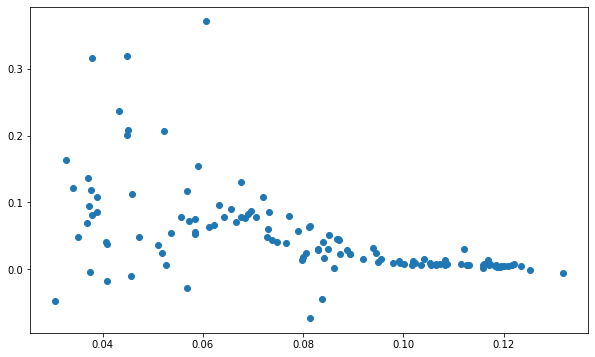

In [95]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = landcoverPC2_df.landcoverPC2_attention, 
           y = landcoverPC2_df.AveragelandcoverPC2)

print(scipy.stats.spearmanr(landcoverPC2_df.landcoverPC2_attention, landcoverPC2_df.AveragelandcoverPC2))
print(scipy.stats.pearsonr(landcoverPC2_df.landcoverPC2_attention, landcoverPC2_df.AveragelandcoverPC2))

SignificanceResult(statistic=-0.9533087557603687, pvalue=8.258732449754759e-66)
PearsonRResult(statistic=-0.9552371943740382, pvalue=6.543966181985446e-67)


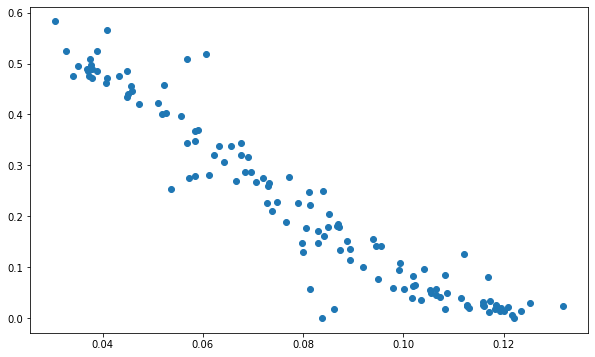

In [96]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = landcoverPC2_df.landcoverPC2_attention, 
           y = landcoverPC2_df.StdlandcoverPC2)

print(scipy.stats.spearmanr(landcoverPC2_df.landcoverPC2_attention, landcoverPC2_df.StdlandcoverPC2))
print(scipy.stats.pearsonr(landcoverPC2_df.landcoverPC2_attention, landcoverPC2_df.StdlandcoverPC2))

In [97]:
landcoverPC2_df.Species[np.argsort(landcoverPC2_df.landcoverPC2_attention)]

97     Rostratula_benghalensis
84               Porzana_fusca
96           Riparia_chinensis
117          Turnix_suscitator
37         Gallinula_chloropus
                ...           
107          Suthora_verreauxi
106            Strix_nivicolum
95         Regulus_goodfellowi
115    Troglodytes_troglodytes
88           Prunella_collaris
Name: Species, Length: 125, dtype: object

In [98]:
[get_chinese_sciname(sp) for sp in landcoverPC2_df.Species[np.argsort(landcoverPC2_df.landcoverPC2_attention)]]

['彩鷸',
 '緋秧雞',
 '棕沙燕',
 '棕三趾鶉',
 '紅冠水雞',
 '棕背伯勞',
 '斑文鳥',
 '紅鳩',
 '黃頭扇尾鶯',
 '褐頭鷦鶯',
 '黑頭文鳥',
 '灰頭鷦鶯',
 '黑翅鳶',
 '栗小鷺',
 '小雲雀',
 '棕扇尾鶯',
 '八哥',
 '灰胸秧雞',
 '白腹秧雞',
 '環頸雉',
 '麻雀',
 '番鵑',
 '珠頸斑鳩',
 '白頭翁',
 '洋燕',
 '粉紅鸚嘴',
 '赤腰燕',
 '岩鷺',
 '斯氏繡眼',
 '南亞夜鷹',
 '烏頭翁',
 '紅頭綠鳩',
 '黑冠麻鷺',
 '小雨燕',
 '翠翼鳩',
 '白腰文鳥',
 '小鵪鶉',
 '臺灣畫眉',
 '樹鵲',
 '黑枕藍鶲',
 '紅嘴黑鵯',
 '領角鴞',
 '東方蜂鷹',
 '灰腳秧雞',
 '小啄木',
 '小彎嘴',
 '鳳頭蒼鷹',
 '松雀鷹',
 '臺灣竹雞',
 '山麻雀',
 '綠鳩',
 '五色鳥',
 '朱鸝',
 '臺灣藍鵲',
 '白環鸚嘴鵯',
 '大彎嘴',
 '大冠鷲',
 '小卷尾',
 '斑紋鷦鶯',
 '綠啄花',
 '頭烏線',
 '山紅頭',
 '草鴞',
 '綠畫眉',
 '繡眼畫眉',
 '臺灣山鷓鴣',
 '林三趾鶉',
 '黃嘴角鴞',
 '灰喉針尾雨燕',
 '林鵰',
 '巨嘴鴉',
 '黃魚鴞',
 '臺灣紫嘯鶇',
 '鉛色水鶇',
 '熊鷹',
 '河烏',
 '灰喉山椒鳥',
 '東方毛腳燕',
 '赤腹山雀',
 '白耳畫眉',
 '灰林鴿',
 '小鶯',
 '棕面鶯',
 '花翅山椒鳥',
 '黃山雀',
 '白尾鴝',
 '白頭鶇',
 '臺灣白喉噪眉',
 '紅胸啄花',
 '小剪尾',
 '黃腹琉璃',
 '棕噪眉',
 '紅頭山雀',
 '臺灣叢樹鶯',
 '黃胸青鶲',
 '黃胸藪眉',
 '青背山雀',
 '松鴉',
 '藍腹鷴',
 '鵂鶹',
 '小翼鶇',
 '冠羽畫眉',
 '大赤啄木',
 '虎斑地鶇',
 '綠啄木',
 '紋翼畫眉',
 '星鴉',
 '臺灣朱雀',
 '茶腹鳾',
 '褐鷽',
 '褐林鴞',
 '臺灣鷦眉',
 '黑長尾雉',
 '煤山雀',
 '褐頭花翼',
 '深山鶯',
 '灰鷽',
 '臺灣噪眉',
 '臺灣白眉林鴝

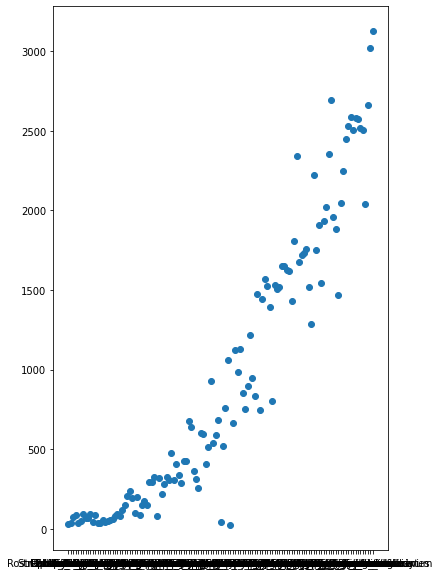

In [99]:
fig, ax = plt.subplots(figsize = (6, 10))

ax.scatter(y = elevation_df.AverageElevation[np.argsort(landcoverPC2_df.landcoverPC2_attention)], 
           x = elevation_df.Species[np.argsort(landcoverPC2_df.landcoverPC2_attention)])

# Landcover PC3

In [100]:
# 初始化物種平均溫度字典
species_avg_landcoverPC3 = {}
species_std_landcoverPC3 = {}

# 確保 month 和 year 是數字類型
species_occ['month'] = species_occ['month'].astype(int)
species_occ['year'] = species_occ['year'].astype(int)

# 為每個物種計算平均溫度
for i_sp, sp in enumerate(species_list_predict):
    print(f'\r{i_sp+1}/{len(species_list_predict)} {sp}', end='')
    # 過濾出當前物種的出現記錄
    occ_sp = species_occ[species_occ.species == sp]
    
    sp_landcoverPC3 = []  # 初始化為空列表
    
    for i_date, date in enumerate(date_list_predict):
        # 讀取溫度影像
        landcoverPC3_path = os.path.join(env_info['dir_base'], env_info['info']['landcover_PC02'][date]['tif_span_avg'])
        with rasterio.open(landcoverPC3_path, 'r') as f:
            landcoverPC3_rst = f.read(1)

        # 過濾出符合日期的出現記錄
        occ_sp_date = occ_sp[(occ_sp.month == int(date.split('-')[1])) & (occ_sp.year == int(date.split('-')[0]))]
        
        if occ_sp_date.empty:
            continue

        # 將緯經度轉換為影像索引
        rows, cols = rasterio.transform.rowcol(
            transform,
            occ_sp_date['decimalLongitude'].values,
            occ_sp_date['decimalLatitude'].values
        )

        # 獲取對應位置的溫度值
        landcoverPC3s = landcoverPC3_rst[rows, cols]

        # 過濾無效溫度數據（如 -9999 值）
        valid_landcoverPC3s = landcoverPC3s.copy()
        valid_landcoverPC3s[landcoverPC3s == -9999] = np.nan
        
        # 存入 sp_landcoverPC3
        sp_landcoverPC3.extend(valid_landcoverPC3s)

    # 計算平均和標準差
    if len(sp_landcoverPC3) > 0:
        species_avg_landcoverPC3[sp] = np.nanmean(sp_landcoverPC3)
        species_std_landcoverPC3[sp] = np.nanstd(sp_landcoverPC3)
    else:
        species_avg_landcoverPC3[sp] = None  # 如果沒有有效數據，設置為 None
        species_std_landcoverPC3[sp] = None
        
# 合併平均值和標準差到同一個 DataFrame
landcoverPC3_df = pd.DataFrame({
    'Species': list(species_avg_landcoverPC3.keys()),
    'AveragelandcoverPC3': list(species_avg_landcoverPC3.values()),
    'StdlandcoverPC3': list(species_std_landcoverPC3.values())
})

# 輸出結果
print(landcoverPC3_df)

landcoverPC3_df['landcoverPC3_attention'] = df_attention_weight['Landcover (PC3)'][landcoverPC3_df.Species].tolist()

125/125 Zosterops_simplexpillusianum                       Species  AveragelandcoverPC3  StdlandcoverPC3
0       Abroscopus_albogularis            -0.005004         0.066245
1        Accipiter_trivirgatus             0.030255         0.242719
2           Accipiter_virgatus             0.010664         0.207165
3    Acridotheres_cristatellus            -0.034228         0.325808
4      Actinodura_morrisoniana            -0.011678         0.023723
..                         ...                  ...              ...
120          Urocissa_caerulea             0.032081         0.144984
121         Yuhina_brunneiceps            -0.007752         0.043389
122    Yungipicus_canicapillus             0.015480         0.259937
123             Zoothera_dauma            -0.020569         0.046877
124          Zosterops_simplex             0.023902         0.304257

[125 rows x 3 columns]


SignificanceResult(statistic=-0.34591090629800303, pvalue=7.774767016611727e-05)
PearsonRResult(statistic=-0.18364442225296723, pvalue=0.04035961101143639)


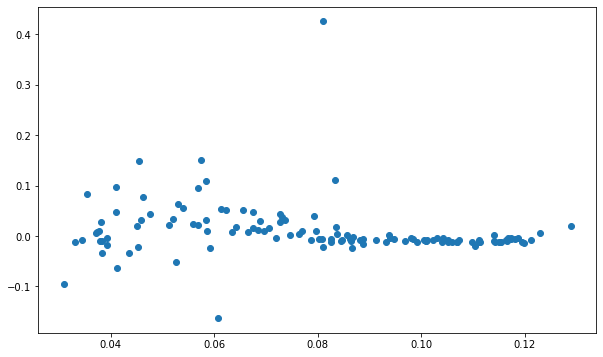

In [101]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = landcoverPC3_df.landcoverPC3_attention, 
           y = landcoverPC3_df.AveragelandcoverPC3)

print(scipy.stats.spearmanr(landcoverPC3_df.landcoverPC3_attention, landcoverPC3_df.AveragelandcoverPC3))
print(scipy.stats.pearsonr(landcoverPC3_df.landcoverPC3_attention, landcoverPC3_df.AveragelandcoverPC3))

SignificanceResult(statistic=-0.9464577572964668, pvalue=3.040920463609715e-62)
PearsonRResult(statistic=-0.9370484440584237, pvalue=4.807275986096754e-58)


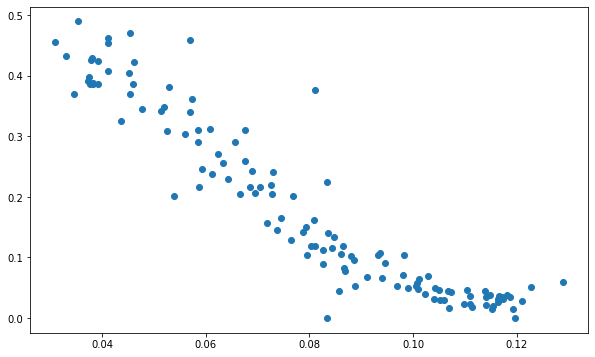

In [102]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = landcoverPC3_df.landcoverPC3_attention, 
           y = landcoverPC3_df.StdlandcoverPC3)

print(scipy.stats.spearmanr(landcoverPC3_df.landcoverPC3_attention, landcoverPC3_df.StdlandcoverPC3))
print(scipy.stats.pearsonr(landcoverPC3_df.landcoverPC3_attention, landcoverPC3_df.StdlandcoverPC3))

In [103]:
[get_chinese_sciname(sp) for sp in landcoverPC3_df.Species[np.argsort(landcoverPC3_df.landcoverPC3_attention)]]

['彩鷸',
 '緋秧雞',
 '棕沙燕',
 '棕三趾鶉',
 '紅冠水雞',
 '棕背伯勞',
 '斑文鳥',
 '紅鳩',
 '黃頭扇尾鶯',
 '褐頭鷦鶯',
 '黑頭文鳥',
 '灰頭鷦鶯',
 '黑翅鳶',
 '栗小鷺',
 '小雲雀',
 '棕扇尾鶯',
 '八哥',
 '灰胸秧雞',
 '白腹秧雞',
 '環頸雉',
 '麻雀',
 '番鵑',
 '珠頸斑鳩',
 '白頭翁',
 '洋燕',
 '粉紅鸚嘴',
 '赤腰燕',
 '岩鷺',
 '斯氏繡眼',
 '南亞夜鷹',
 '烏頭翁',
 '紅頭綠鳩',
 '黑冠麻鷺',
 '小雨燕',
 '翠翼鳩',
 '白腰文鳥',
 '小鵪鶉',
 '臺灣畫眉',
 '樹鵲',
 '黑枕藍鶲',
 '紅嘴黑鵯',
 '領角鴞',
 '東方蜂鷹',
 '灰腳秧雞',
 '小啄木',
 '小彎嘴',
 '鳳頭蒼鷹',
 '松雀鷹',
 '臺灣竹雞',
 '山麻雀',
 '綠鳩',
 '五色鳥',
 '朱鸝',
 '臺灣藍鵲',
 '白環鸚嘴鵯',
 '大彎嘴',
 '大冠鷲',
 '小卷尾',
 '斑紋鷦鶯',
 '綠啄花',
 '頭烏線',
 '山紅頭',
 '草鴞',
 '綠畫眉',
 '繡眼畫眉',
 '臺灣山鷓鴣',
 '林三趾鶉',
 '黃嘴角鴞',
 '灰喉針尾雨燕',
 '林鵰',
 '巨嘴鴉',
 '黃魚鴞',
 '臺灣紫嘯鶇',
 '鉛色水鶇',
 '熊鷹',
 '河烏',
 '灰喉山椒鳥',
 '東方毛腳燕',
 '赤腹山雀',
 '白耳畫眉',
 '灰林鴿',
 '小鶯',
 '棕面鶯',
 '花翅山椒鳥',
 '黃山雀',
 '白尾鴝',
 '白頭鶇',
 '臺灣白喉噪眉',
 '紅胸啄花',
 '小剪尾',
 '黃腹琉璃',
 '棕噪眉',
 '紅頭山雀',
 '臺灣叢樹鶯',
 '黃胸青鶲',
 '黃胸藪眉',
 '青背山雀',
 '松鴉',
 '藍腹鷴',
 '鵂鶹',
 '小翼鶇',
 '冠羽畫眉',
 '大赤啄木',
 '虎斑地鶇',
 '綠啄木',
 '紋翼畫眉',
 '星鴉',
 '臺灣朱雀',
 '茶腹鳾',
 '褐鷽',
 '褐林鴞',
 '臺灣鷦眉',
 '黑長尾雉',
 '煤山雀',
 '褐頭花翼',
 '深山鶯',
 '灰鷽',
 '臺灣噪眉',
 '臺灣白眉林鴝

# Relative Humidity

In [104]:
# 初始化物種平均溫度字典
species_avg_hurs = {}
species_std_hurs = {}

# 確保 month 和 year 是數字類型
species_occ['month'] = species_occ['month'].astype(int)
species_occ['year'] = species_occ['year'].astype(int)

# 為每個物種計算平均溫度
for i_sp, sp in enumerate(species_list_predict):
    print(f'\r{i_sp+1}/{len(species_list_predict)} {sp}', end='')
    # 過濾出當前物種的出現記錄
    occ_sp = species_occ[species_occ.species == sp]
    
    sp_hurs = []  # 初始化為空列表
    
    for i_date, date in enumerate(date_list_predict):
        # 讀取溫度影像
        hurs_path = os.path.join(env_info['dir_base'], env_info['info']['hurs'][date]['tif_span_avg'])
        with rasterio.open(hurs_path, 'r') as f:
            hurs_rst = f.read(1)

        # 過濾出符合日期的出現記錄
        occ_sp_date = occ_sp[(occ_sp.month == int(date.split('-')[1])) & (occ_sp.year == int(date.split('-')[0]))]
        
        if occ_sp_date.empty:
            continue

        # 將緯經度轉換為影像索引
        rows, cols = rasterio.transform.rowcol(
            transform,
            occ_sp_date['decimalLongitude'].values,
            occ_sp_date['decimalLatitude'].values
        )

        # 獲取對應位置的溫度值
        hurss = hurs_rst[rows, cols]

        # 過濾無效溫度數據（如 -9999 值）
        valid_hurss = hurss.copy()
        valid_hurss[hurss == -9999] = np.nan
        
        # 存入 sp_hurs
        sp_hurs.extend(valid_hurss)

    # 計算平均和標準差
    if len(sp_hurs) > 0:
        species_avg_hurs[sp] = np.nanmean(sp_hurs)
        species_std_hurs[sp] = np.nanstd(sp_hurs)
    else:
        species_avg_hurs[sp] = None  # 如果沒有有效數據，設置為 None
        species_std_hurs[sp] = None
        
# 合併平均值和標準差到同一個 DataFrame
hurs_df = pd.DataFrame({
    'Species': list(species_avg_hurs.keys()),
    'Averagehurs': list(species_avg_hurs.values()),
    'Stdhurs': list(species_std_hurs.values())
})

# 輸出結果
print(hurs_df)

hurs_df['hurs_attention'] = df_attention_weight['Relative humidity'][hurs_df.Species].tolist()

125/125 Zosterops_simplexpillusianum                       Species  Averagehurs     Stdhurs
0       Abroscopus_albogularis  6525.606934  372.607574
1        Accipiter_trivirgatus  6455.765137  335.645081
2           Accipiter_virgatus  6474.495605  350.455994
3    Acridotheres_cristatellus  6349.963379  224.367355
4      Actinodura_morrisoniana  6328.457031  441.008453
..                         ...          ...         ...
120          Urocissa_caerulea  6573.087891  352.498077
121         Yuhina_brunneiceps  6525.440430  423.205841
122    Yungipicus_canicapillus  6468.866699  349.954041
123             Zoothera_dauma  6556.268555  402.224823
124          Zosterops_simplex  6424.559570  300.449188

[125 rows x 3 columns]


SignificanceResult(statistic=-0.15562519201228878, pvalue=0.0830889341162088)
PearsonRResult(statistic=-0.26664388753710566, pvalue=0.00264851347973007)


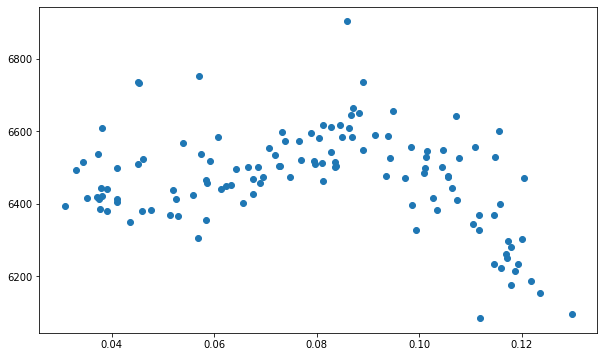

In [105]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = hurs_df.hurs_attention, 
           y = hurs_df.Averagehurs)

print(scipy.stats.spearmanr(hurs_df.hurs_attention, hurs_df.Averagehurs))
print(scipy.stats.pearsonr(hurs_df.hurs_attention, hurs_df.Averagehurs))

SignificanceResult(statistic=0.7359877112135176, pvalue=1.4071660167114004e-22)
PearsonRResult(statistic=0.6082322651905848, pvalue=5.3458467798515476e-14)


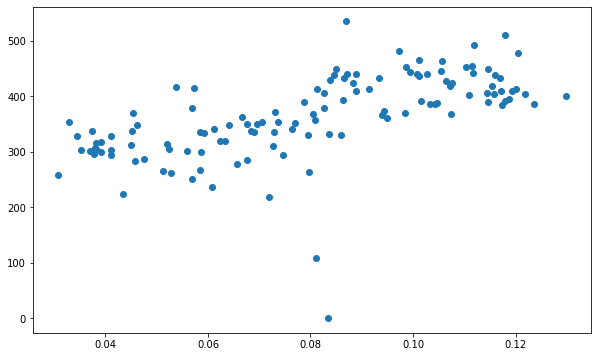

In [106]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = hurs_df.hurs_attention, 
           y = hurs_df.Stdhurs)

print(scipy.stats.spearmanr(hurs_df.hurs_attention, hurs_df.Stdhurs))
print(scipy.stats.pearsonr(hurs_df.hurs_attention, hurs_df.Stdhurs))

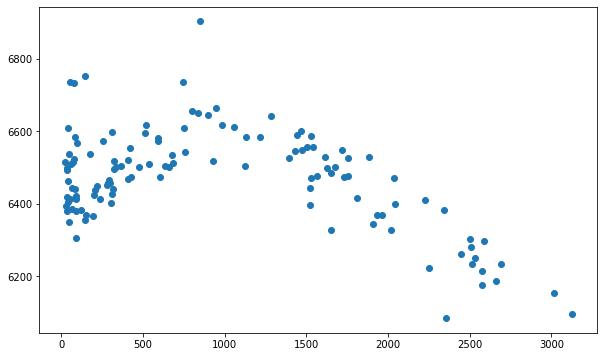

In [107]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = elevation_df.AverageElevation, 
           y = hurs_df.Averagehurs)
    

In [121]:
env_list

['EVI',
 'clt',
 'cmi',
 'hurs',
 'landcover_PC00',
 'landcover_PC01',
 'landcover_PC02',
 'landcover_PC03',
 'landcover_PC04',
 'pet',
 'pr',
 'rsds',
 'sfcWind',
 'tas',
 'vpd']

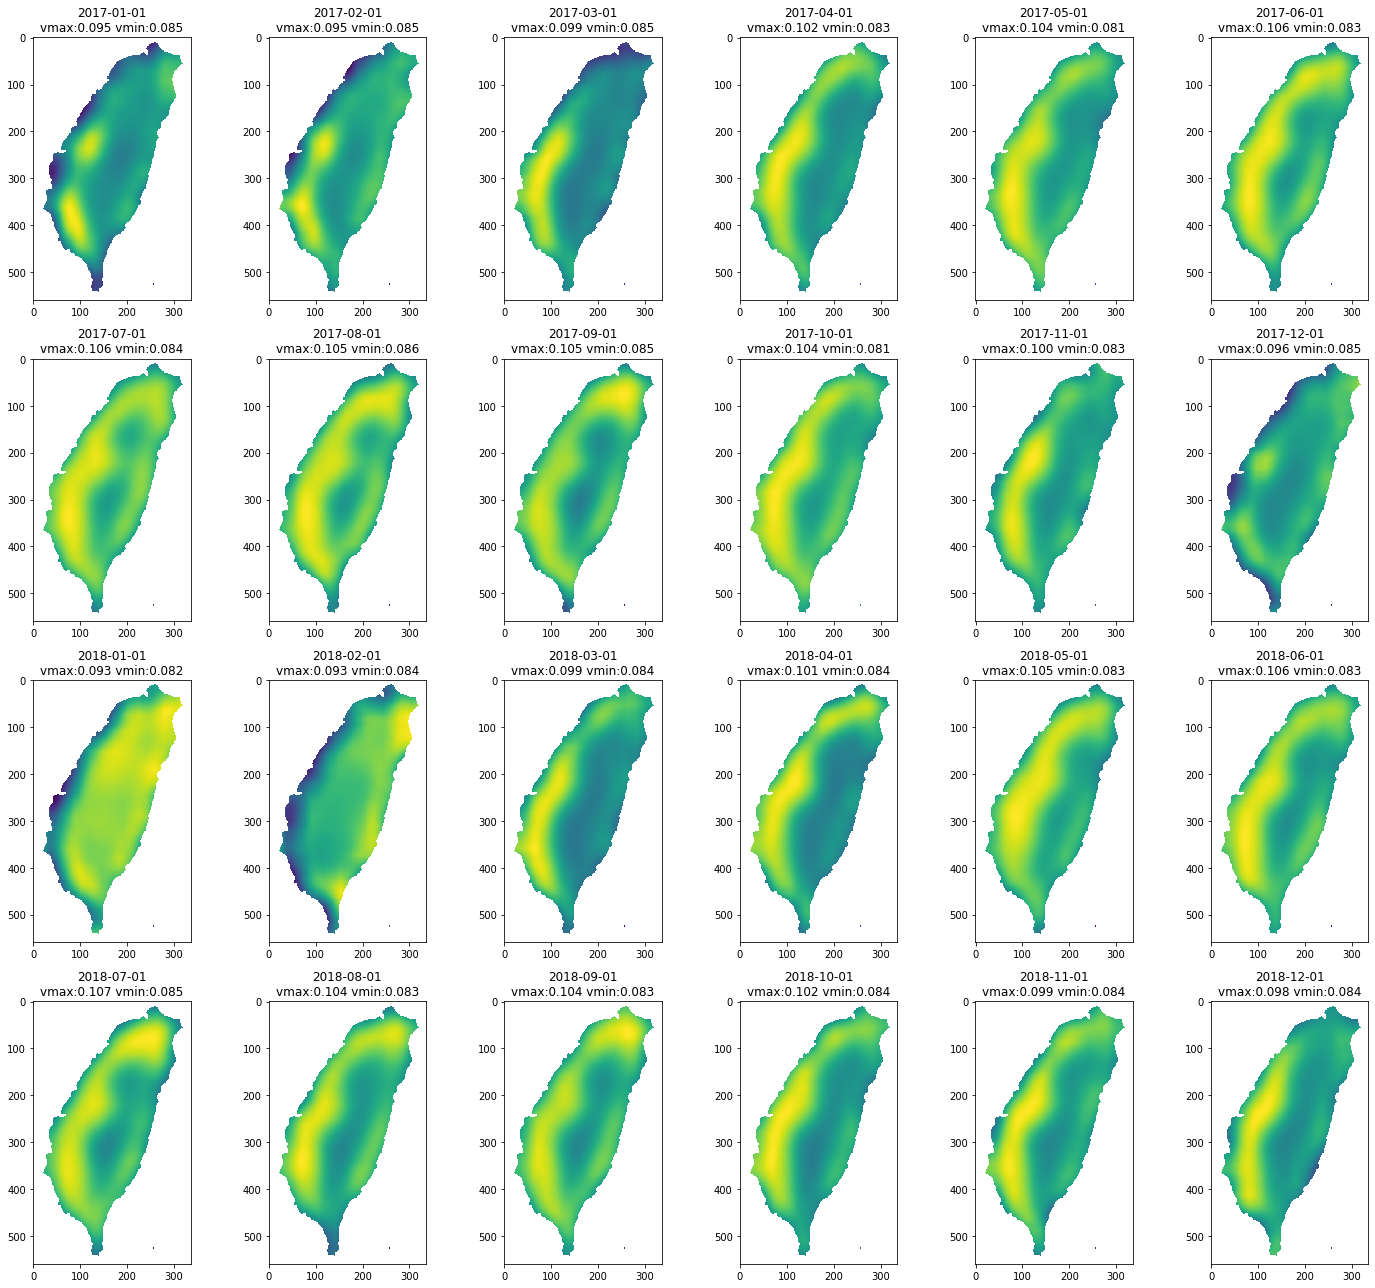

In [187]:
species = 'Yuhina_brunneiceps'
fig, ax = plt.subplots(4, 6, figsize=(20, 18))  # 建立 4x3 子圖

# 遍歷最後 12 個日期
for i_date, date in enumerate(date_list_predict[-24:]):
    with h5py.File(os.path.join(predicts_path, 'attention', f'{species}_{date}_attention.h5'), 'r') as hf:
        rst = hf['vpd'][:]
    # 計算子圖在 4x3 布局中的位置
    row, col = divmod(i_date, 6)
    ax[row, col].imshow(np.where(rst == -9999, np.nan, rst), cmap='viridis')  # 處理 -9999 為 NaN 並顯示圖像
    ax[row, col].set_title(f'{date}\nvmax:{np.nanmax(rst):.3f} vmin:{np.nanmin(rst[rst!=-9999]):.3f}')  # 設置標題

# 隱藏多餘的子圖
for i_date in range(len(date_list_predict[-12:]), 12):
    row, col = divmod(i_date, 6)
    ax[row, col].axis('off')

plt.tight_layout()  # 自動調整子圖間距
plt.show()


In [57]:
# 初始化結果字典
species_avg_env = {env: {} for env in env_list}
species_std_env = {env: {} for env in env_list}
species_attention_env = {env: {} for env in env_list}

# 確保 month 和 year 是數字類型
species_occ['month'] = species_occ['month'].astype(int)
species_occ['year'] = species_occ['year'].astype(int)

# 計算每個環境因子的平均值、標準差和 attention
for env in env_list:
    print(f"Processing {env}...")
    for i_sp, sp in enumerate(species_list_predict):
        print(f'\r{i_sp+1}/{len(species_list_predict)} {sp}', end='')
        # 過濾出當前物種的出現記錄
        occ_sp = species_occ[species_occ.species == sp]
        
        sp_env_values = []  # 初始化為空列表
        
        for i_date, date in enumerate(date_list_predict):
            # 讀取環境因子影像
            env_path = os.path.join(env_info['dir_base'], env_info['info'][env][date]['tif_span_avg'])
            with rasterio.open(env_path, 'r') as f:
                env_rst = f.read(1)

            # 過濾出符合日期的出現記錄
            occ_sp_date = occ_sp[(occ_sp.month == int(date.split('-')[1])) & (occ_sp.year == int(date.split('-')[0]))]
            
            if occ_sp_date.empty:
                continue

            # 將緯經度轉換為影像索引
            rows, cols = rasterio.transform.rowcol(
                transform,
                occ_sp_date['decimalLongitude'].values,
                occ_sp_date['decimalLatitude'].values
            )

            # 獲取對應位置的環境因子值
            env_values = env_rst[rows, cols]

            # 過濾無效數據（如 -9999 值）
            valid_env_values = env_values.copy()
            valid_env_values[env_values == -9999] = np.nan
            
            # 存入 sp_env_values
            sp_env_values.extend(valid_env_values)

        # 計算平均和標準差
        if len(sp_env_values) > 0:
            species_avg_env[env][sp] = np.nanmean(sp_env_values)
            species_std_env[env][sp] = np.nanstd(sp_env_values)
        else:
            species_avg_env[env][sp] = None  # 如果沒有有效數據，設置為 None
            species_std_env[env][sp] = None

        # 獲取 attention 值
        species_attention_env[env][sp] = df_attention_weight.at[sp, env_list_detail[env_list.index(env)]]

# 合併所有環境因子的平均值、標準差和 attention 到單一 DataFrame
result_data = []
for sp in species_list_predict:
    row = {'Species': sp}
    for i, env in enumerate(env_list):
        row[f'{env_list_detail[i]}_avg'] = species_avg_env[env].get(sp, None)
        row[f'{env_list_detail[i]}_std'] = species_std_env[env].get(sp, None)
        row[f'{env_list_detail[i]}_attention'] = species_attention_env[env].get(sp, None)
    result_data.append(row)

# 轉為 Pandas DataFrame
result_df = pd.DataFrame(result_data)

# 輸出結果
print(result_df)


# result_df.to_csv(os.path.join(plot_path_heatmap, 'df_env_attention_all.csv'), index = None)

Processing EVI...
125/125 Zosterops_simplexpillusianumProcessing clt...
125/125 Zosterops_simplexpillusianumProcessing cmi...
125/125 Zosterops_simplexpillusianumProcessing hurs...
125/125 Zosterops_simplexpillusianumProcessing landcover_PC00...
125/125 Zosterops_simplexpillusianumProcessing landcover_PC01...
125/125 Zosterops_simplexpillusianumProcessing landcover_PC02...
125/125 Zosterops_simplexpillusianumProcessing landcover_PC03...
125/125 Zosterops_simplexpillusianumProcessing landcover_PC04...
125/125 Zosterops_simplexpillusianumProcessing pet...
125/125 Zosterops_simplexpillusianumProcessing pr...
125/125 Zosterops_simplexpillusianumProcessing rsds...
125/125 Zosterops_simplexpillusianumProcessing sfcWind...
125/125 Zosterops_simplexpillusianumProcessing tas...
125/125 Zosterops_simplexpillusianumProcessing vpd...
125/125 Zosterops_simplexpillusianum                       Species      EVI_avg      EVI_std  EVI_attention  \
0       Abroscopus_albogularis  4312.157227   952.53241

In [58]:
# result_df = pd.read_csv(os.path.join(plot_path_heatmap, 'df_env_attention_all.csv'))
filter_result_df = result_df[(result_df.Species != 'Turnix_sylvaticus') & (result_df.Species != 'Tyto_longimembris')]

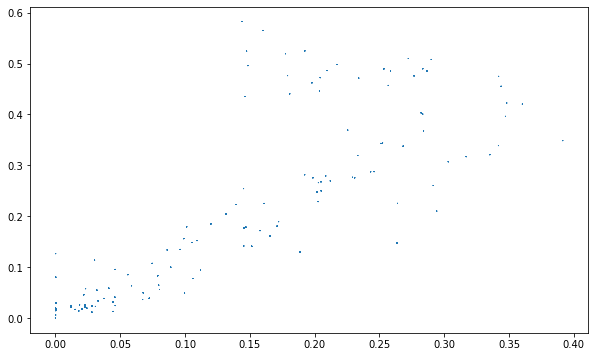

In [59]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(x = filter_result_df['Landcover (PC5)_std'], 
           y = filter_result_df['Landcover (PC2)_std'], 
           s = (filter_result_df['Landcover (PC5)_attention'])**3 *1000000)

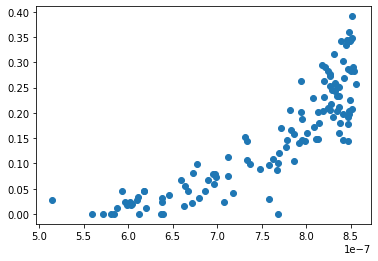

In [60]:
plt.scatter(y = filter_result_df['Landcover (PC5)_std'], 
            x = filter_result_df['Landcover (PC5)_attention'])

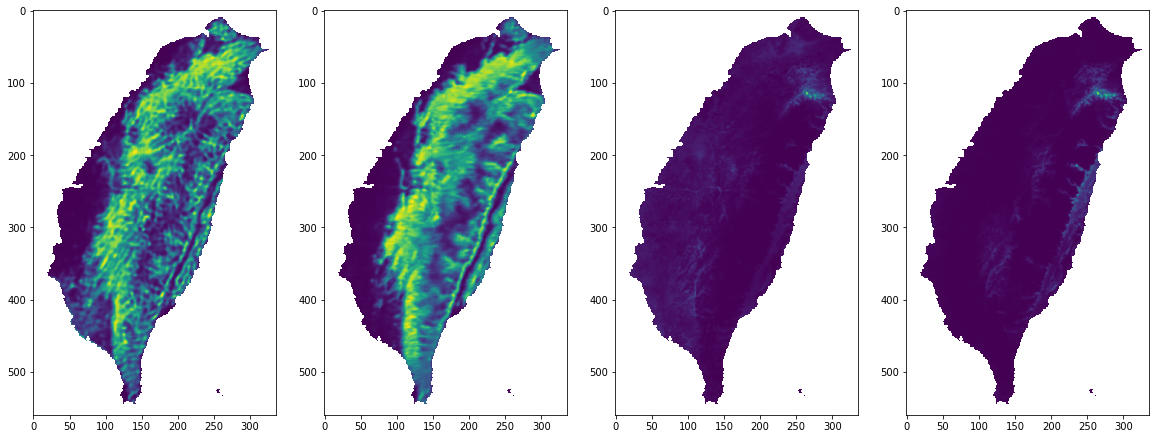

In [136]:
species = 'Corvus_macrorhynchos'
date = '2018-04-01'

fig, ax = plt.subplots(1, 4, figsize=(20, 12))

# 第一張圖
ax[0].imshow(cv2.imread(DeepSDM_template.replace('[SPECIES]', species).replace('[TIME]', date), cv2.IMREAD_UNCHANGED))

# 第二張圖
ax[1].imshow(cv2.imread(f'/home/klok0126/DeepSDM/predicts/5dfac203dda746e7802e215d0e90fb03/tif/{species}_{date}_predict.tif', cv2.IMREAD_UNCHANGED))

# 第三張圖
image3 = cv2.imread(maxent_template.replace('[SPECIES]', species).replace('[TIME]', date), cv2.IMREAD_UNCHANGED)
image3 = np.where(image3 < 0, np.nan, image3)  # 將值為 -9999 的像素替換為 np.nan
ax[2].imshow(image3)

# 第四張圖
image4 = cv2.imread(f'/home/klok0126/DeepSDM/predicts_maxent/5dfac203dda746e7802e215d0e90fb03/tif/all/{species}_{date}_maxent_all_season_5dfac203dda746e7802e215d0e90fb03.tif', cv2.IMREAD_UNCHANGED)
image4 = np.where(image4 < 0, np.nan, image4)  # 將值為 -9999 的像素替換為 np.nan
ax[3].imshow(image4, vmax = np.nanmax(image4), vmin = np.nanmin(image4))

plt.show()
